# Results 5 June

There are two data tables in the analysis:  
- accuracies table contains the data for each trial (one row = one trial)  
- fixations table contains variables for each fixation in a given trial (one row = one fixation)
<br>
The two can be merged if only one row per trial is selected from the fixaions table

In [1]:
from tools import *
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ks_2samp
from IPython.display import display
style.use('ggplot')
d = manual_load_data('clean_data.pkl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

In [2]:
markers = {}
markers['P07'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P08'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P09'] = {'index': 'index7', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P11'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P12'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P16'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist12'}
markers['P18'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P19'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P21'] = {'index': 'index7', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P22'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P23'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P25'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P26'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P29'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}

pd.DataFrame(markers)

P07      P08      P09      P11      P12      P16      P18      P19  \
index   index8   index8   index7   index8   index8   index8   index8   index8   
thumb   thumb9   thumb9   thumb9   thumb9   thumb9   thumb9   thumb9   thumb9   
wrist  wrist11  wrist11  wrist11  wrist11  wrist11  wrist12  wrist11  wrist11   

           P21      P22      P23      P25      P26      P29  
index   index7   index8   index8   index8   index8   index8  
thumb   thumb9   thumb9   thumb9   thumb9   thumb9   thumb9  
wrist  wrist11  wrist11  wrist11  wrist11  wrist11  wrist11

In [3]:
def std_error(values):
    if type(values) is not np.ndarray:
        values = np.array(values)
    std_err = np.std(values) / np.sqrt(len(values))
    
    return std_err

## Distance to object's centre for index & gaze

In [4]:
accuracies = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'
    wrist_vel = markers[pid]['wrist'] + 'vel'
    
    for tid, trial in subj['trials'].items():
        
        # identify the reach onset frame
        sm = np.array(trial['startmovement'])
        ro_frame = np.where(sm == 1)[0][0]
        
        # get the fixations table for a trial
        fix = pd.DataFrame(trial['fix'])
                
        # find the eye and index to object distances
        index_object = trial[index_x][-1] - trial['objectx'][-1]
        eyes_object_final = fix.iloc[-1]['centre_x'] - trial['objectx'][-1] # final fixation in a trial
        
        ro_fix = fix[(fix['start_frame'] <= ro_frame) & (fix['end_frame'] >= ro_frame)]
        
        if not ro_fix['centre_x'].any():
            ro_fix_x = fix[fix['start_frame'] >= ro_frame]['centre_x'].iloc[0]
        else:
            ro_fix_x = ro_fix['centre_x'].iloc[0]
            
        eyes_object_ro = ro_fix_x - trial['objectx'][ro_frame]
        
        if 'RightToLeft' in trial['name']:
            index_object *= -1
            eyes_object_final *= -1
            eyes_object_ro *= -1
            
        # reach duration in frames
        reach_duration = len(np.where(sm == 1)[0])
        
        # peak velocity frame
        vel = np.array(trial[wrist_vel])
        peak_vel = np.where(vel == max(vel))[0][0]
        
        # wrist deceleration time in frames
        wrist_decel = len(vel[peak_vel:])
        
        # reaction time: reach initiation frame - tone frame (880 is when the tone starts to play)
        reaction = ro_frame - 880
            
        cond = trial['name'][6:-4]
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['condition'] = cond
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        to_add['reach_duration'] = reach_duration
        to_add['peak_vel'] = peak_vel
        to_add['wrist_decel'] = wrist_decel
        to_add['reaction'] = reaction
        to_add['index_object'] = index_object
        to_add['eyes_object_final'] = eyes_object_final
        to_add['eyes_object_ro'] = eyes_object_ro

        
        accuracies = accuracies.append(to_add, ignore_index = True)

In [5]:
accuracies.sort_values(by = 'condition').head()

condition  eyes_object_final  eyes_object_ro  \
528  Occlusion_Cue_LeftToRight          -0.050434        0.028155   
575  Occlusion_Cue_LeftToRight          -0.005141        0.025639   
163  Occlusion_Cue_LeftToRight          -0.039690       -0.001690   
162  Occlusion_Cue_LeftToRight          -0.061421       -0.033569   
484  Occlusion_Cue_LeftToRight          -0.073424       -0.083446   

     index_object    p  peak_vel  reach_duration  reaction  ro_frame trial  \
528     -0.072357  P08     983.0           137.0      64.0     944.0    t2   
575      0.002128  P29     952.0            61.0      47.0     927.0    t1   
163     -0.050016  P12     941.0            77.0      32.0     912.0    t1   
162     -0.059216  P12     940.0            70.0      34.0     914.0    t3   
484     -0.057881  P09     957.0            58.0      46.0     926.0    t1   

     wrist_decel  
528        100.0  
575         36.0  
163         48.0  
162         44.0  
484         27.0

In [6]:
inter1 = accuracies.groupby(['p', 'condition']).aggregate(np.mean)
inter2 = inter1.reset_index(level = ['condition'])
meanPerCondition = inter2.groupby('condition').aggregate(np.mean)

meanPerCondition

eyes_object_final  eyes_object_ro  index_object  \
condition                                                                      
Occlusion_Cue_LeftToRight            -0.059617       -0.032819     -0.063311   
Occlusion_Cue_RightToLeft            -0.066159       -0.031366     -0.056764   
Occlusion_NoCue_LeftToRight          -0.065072       -0.036109     -0.067783   
Occlusion_NoCue_RightToLeft          -0.063816       -0.028168     -0.055767   
Visible_Cue_LeftToRight              -0.010928        0.007100     -0.010830   
Visible_Cue_RightToLeft              -0.010793        0.005442     -0.000471   
Visible_NoCue_LeftToRight            -0.016111        0.004332     -0.011659   
Visible_NoCue_RightToLeft            -0.011710        0.004982     -0.000841   

                               peak_vel  reach_duration   reaction  \
condition                                                            
Occlusion_Cue_LeftToRight    955.041667       75.716667  42.796429   
Occlusion_Cue_RightToLeft    958.670238       85.269048  47.086905   
Occlusion_NoCue_LeftToRight  954.040476       73.716667  41.746429   
Occlusion_NoCue_RightToLeft  958.392857       83.429762  45.853571   
Visible_Cue_LeftToRight      948.565476       71.800000  38.472619   
Visible_Cue_RightToLeft      957.169048       79.770238  41.958333   
Visible_NoCue_LeftToRight    948.159524       71.450000  38.461905   
Visible_NoCue_RightToLeft    956.901190       80.522619  42.016667   

                               ro_frame  wrist_decel  
condition                                             
Occlusion_Cue_LeftToRight    922.796429    43.705952  
Occlusion_Cue_RightToLeft    927.086905    54.096429  
Occlusion_NoCue_LeftToRight  921.746429    41.610714  
Occlusion_NoCue_RightToLeft  925.853571    51.175000  
Visible_Cue_LeftToRight      918.472619    41.842857  
Visible_Cue_RightToLeft      921.958333    44.702381  
Visible_NoCue_LeftToRight    918.461905    41.919048  
Visible_NoCue_RightToLeft    922.016667    45.723810

In [7]:
inter3 = inter1.reset_index(level = ['p', 'condition'])
anovaTable = inter3.pivot(index = 'p', columns = 'condition', values = 'index_object')

### Accuracy per condition

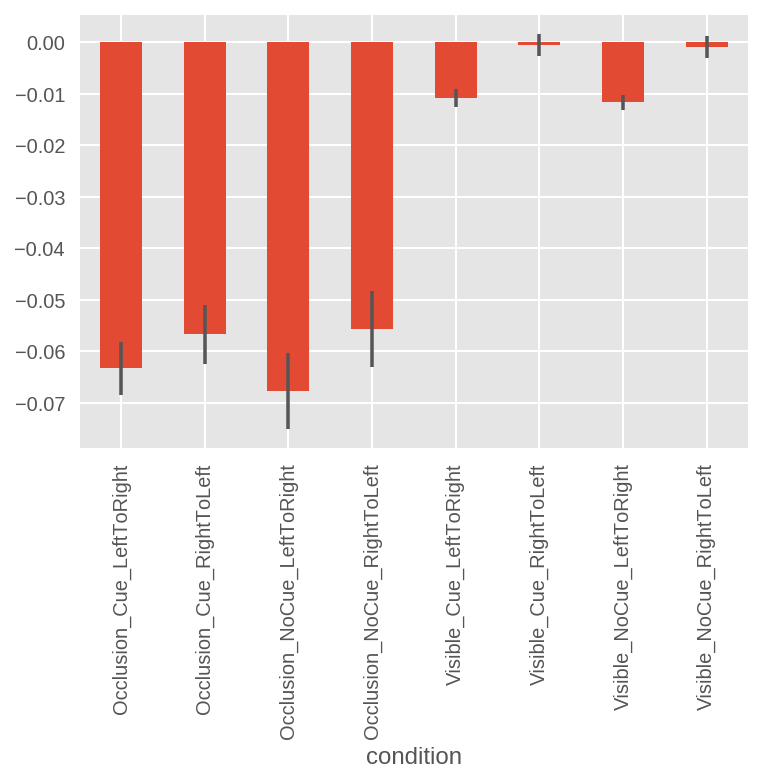

In [8]:
anovaTable.mean(axis = 0).plot(kind = 'bar', yerr = anovaTable.std(axis = 0) / np.sqrt(len(anovaTable)))
plt.show()

### Accuracy per participant

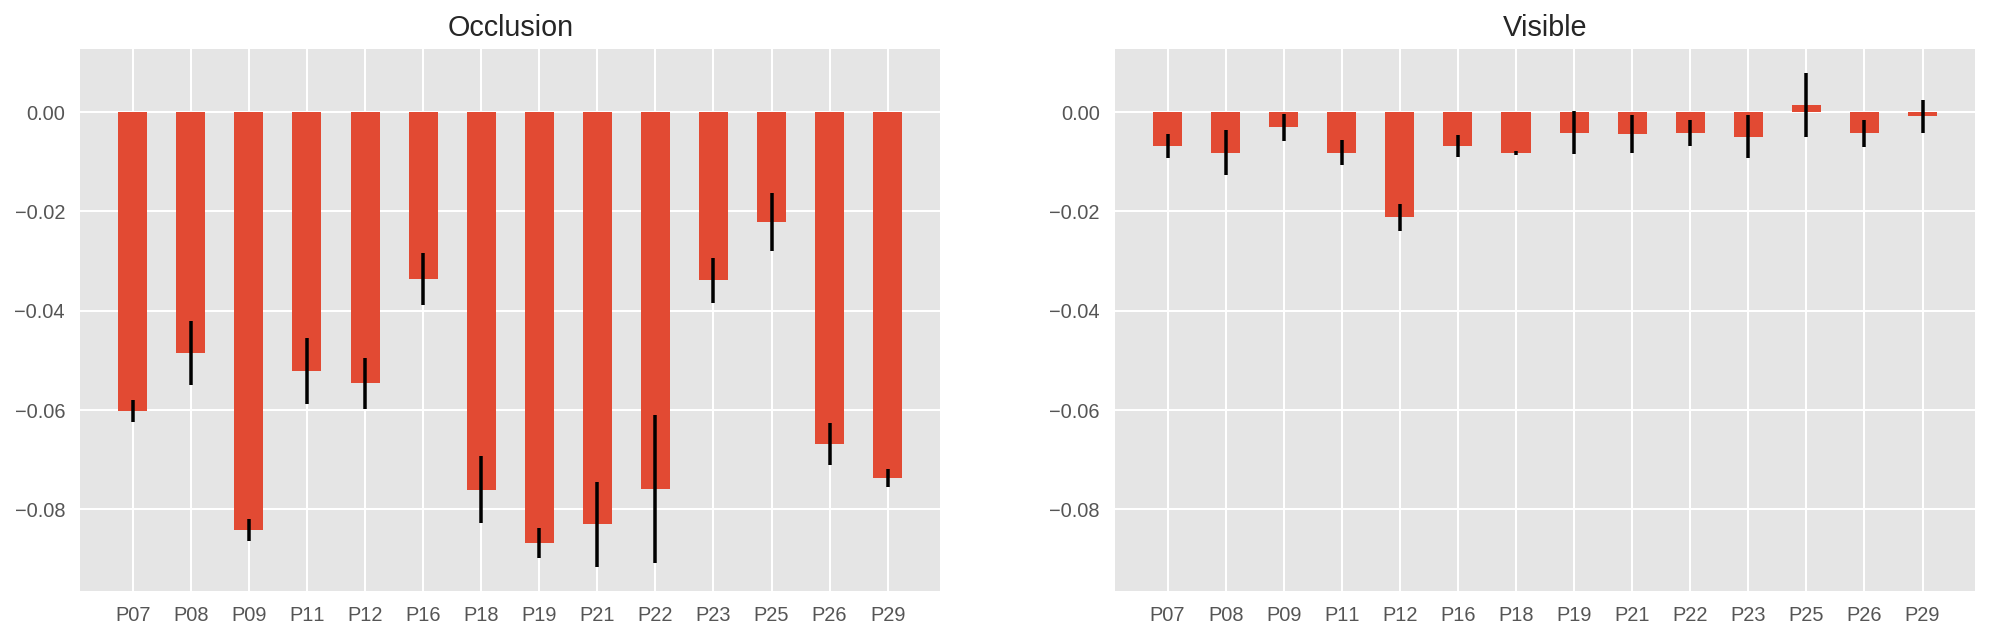

In [9]:
fig = plt.figure(figsize = [17, 5])

ind = np.arange(len(anovaTable))
width = 0.5

ax1 = fig.add_subplot(121)
ax1.bar(ind, anovaTable.iloc[:, 0:4].mean(axis = 1), width, yerr = anovaTable.iloc[:, 0:4].apply(std_error, axis = 1))
ax1.set_xticks(ind)
ax1.set_xticklabels(anovaTable.index)
ax1.set_title('Occlusion')

ax2 = fig.add_subplot(122, sharey = ax1)
ax2.bar(ind, anovaTable.iloc[:, 4:].mean(axis = 1), width, yerr = anovaTable.iloc[:, 4:].apply(std_error, axis = 1))
ax2.set_xticks(ind)
ax2.set_xticklabels(anovaTable.index)
ax2.set_title('Visible')

plt.show()

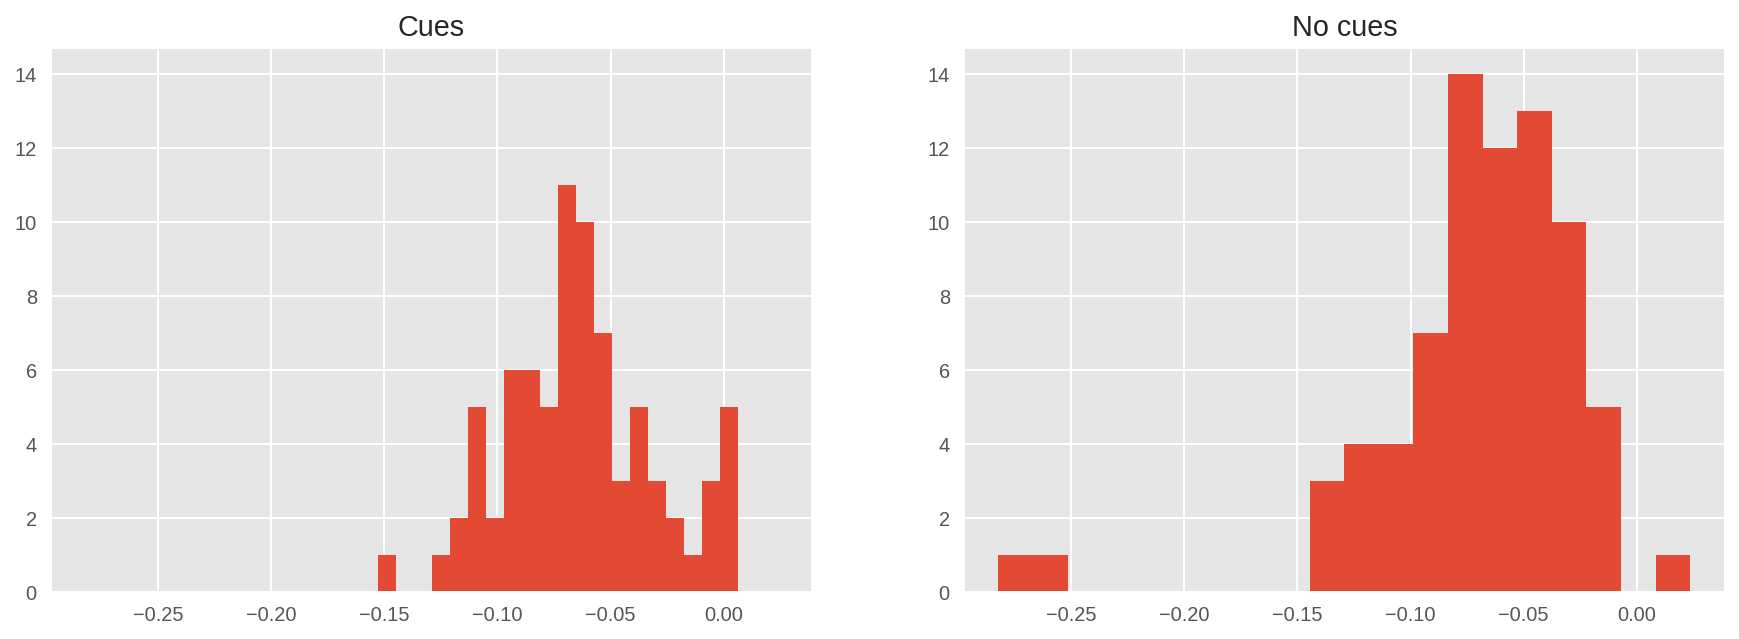

In [10]:
# Distribution of grasping distances from the target COM

fig = plt.figure(figsize = [15, 5])

ax1 = fig.add_subplot(121)
ax1.hist(accuracies[accuracies['condition'] == 'Occlusion_Cue_LeftToRight']['index_object'], bins = 20)
ax1.set_title('Cues')

ax2 = fig.add_subplot(122, sharex = ax1, sharey = ax1)
ax2.hist(accuracies[accuracies['condition'] == 'Occlusion_NoCue_LeftToRight']['index_object'], bins = 20)
ax2.set_title('No cues')


plt.show()

### Reaction time

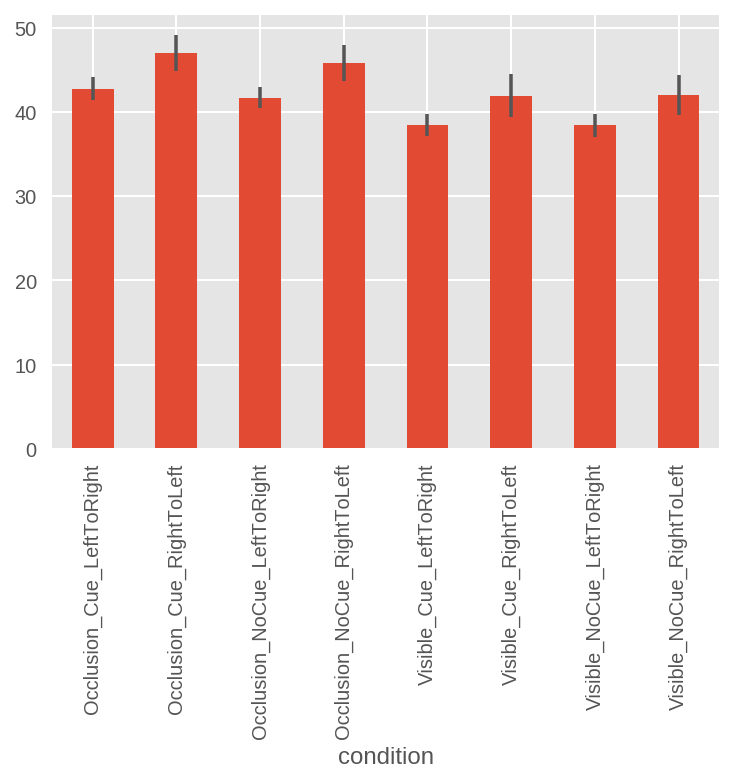

In [11]:
rt = accuracies.groupby(['p', 'condition'])['reaction'] \
               .apply(np.mean) \
               .reset_index() \
               .groupby('condition') \
               .aggregate([np.mean, std_error])
rt['reaction']['mean'].plot(kind = 'bar', yerr = rt['reaction']['std_error'])
plt.show()

In [12]:
# Convert the reaction time data frame to long format for anova

rt_anova = accuracies.groupby(['p', 'condition'])['reaction'] \
                     .apply(np.mean) \
                     .reset_index()

# rt_anova.pivot(index = 'p', columns = 'condition', values = 'reaction').to_csv('rt.csv')        

vf = []
cue = []
direction = []

for row in rt_anova.iterrows():
    if 'Occlusion_' in row[1][1]:
        vf.append('occlusion')
    elif 'Visible_' in row[1][1]:
        vf.append('visible')
    if '_Cue_' in row[1][1]:
        cue.append('cue')
    elif '_NoCue_' in row[1][1]:
        cue.append('nocue')
    if '_LeftToRight' in row[1][1]:
        direction.append('rightward')
    elif '_RightToLeft' in row[1][1]:
        direction.append('leftward')

rt_anova['vf'] = vf
rt_anova['cue'] = cue
rt_anova['dir'] = direction
rt_anova = rt_anova.drop('condition', axis = 1)

In [13]:
rt_anova.head()

p  reaction         vf    cue        dir
0  P07      51.5  occlusion    cue  rightward
1  P07      62.0  occlusion    cue   leftward
2  P07      45.4  occlusion  nocue  rightward
3  P07      60.5  occlusion  nocue   leftward
4  P07      47.6    visible    cue  rightward

In [14]:
%%R -i rt_anova
# http://blog.revolutionanalytics.com/2016/01/pipelining-r-python.html

options(contrasts = c("contr.helmert", "contr.poly"))
fit <- aov(reaction ~ vf * cue * dir + Error(p / (vf * cue * dir)), data = rt_anova)


summary(fit)


Error: p
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 13   4027   309.7               

Error: p:vf
          Df Sum Sq Mean Sq F value   Pr(>F)    
vf         1  480.7   480.7   22.88 0.000357 ***
Residuals 13  273.1    21.0                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: p:cue
          Df Sum Sq Mean Sq F value Pr(>F)
cue        1   8.75   8.747   1.952  0.186
Residuals 13  58.24   4.480               

Error: p:dir
          Df Sum Sq Mean Sq F value Pr(>F)  
dir        1  417.1   417.1   5.575 0.0345 *
Residuals 13  972.5    74.8                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: p:vf:cue
          Df Sum Sq Mean Sq F value   Pr(>F)    
vf:cue     1  9.508   9.508   20.62 0.000554 ***
Residuals 13  5.994   0.461                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: p:vf:dir
          Df Sum Sq Mean Sq F value Pr(>F)
vf:dir     1   3.22   3.223

## Fixations

In [15]:
cues = [0.353 + n * 0.072 for n in range(8)]
print cues

[0.353, 0.425, 0.497, 0.569, 0.641, 0.713, 0.7849999999999999, 0.857]


In [16]:
# Create a common fixations table

fixations = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'

    for tid, trial in subj['trials'].items():
        
        to_add = pd.DataFrame(trial['fix'])
        
        # identify the reach onset frame
        sm = trial['startmovement']
        ro_frame = np.where(np.array(sm) == 1)[0][0]
                        
        # identify the last fixation in a trial (or just the last row)
        to_add['time_interval'] = None
        to_add.loc[to_add.index[-1], 'time_interval'] = 3
        
        # add the data
        to_add['p'] = pid
        to_add['condition'] = trial['name'][6:-4]
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        
        # remove the dispersion column
        to_add.drop('dispersion', axis = 1, inplace = True)
 
        fixations = fixations.append(to_add, ignore_index = True)


In [17]:
# Determine the time interval 
# 0 = before occlusion. frames 0-495
# 1 = visual pursuit. frames 496 - reach onset
# 2 = reach onset - time of contact-1
# 3 = time of contact

time_interval = []

for index, row in fixations.iterrows():
    if row['time_interval'] == 3:
        time_interval.append(3)
        continue
    elif row['start_frame'] <= 495:
        time_interval.append(0)
    elif 495 < row['start_frame'] < row['ro_frame']:
        time_interval.append(1)
    elif row['start_frame'] >= row['ro_frame']:
        time_interval.append(2)

fixations['time_interval'] = time_interval

In [18]:
# Detect the off-screen outliers

fixations['off_screen'] = (fixations.centre_x < 0.34) | (fixations.centre_x > 0.87) | \
    (fixations.centre_z < 0.18) | (fixations.centre_z > 0.48)
    
fixations['off_screen'].value_counts()

False    19594
True       250
Name: off_screen, dtype: int64

In [19]:
# Find the distances between fixations and the closest cue

closest_cue = []
distance = []

for index, row in fixations.iterrows():
    dist = [row['centre_x'] - cue for cue in cues]
    ind, = np.where(np.abs(dist) == min(np.abs(dist)))
    closest_cue.append(ind[0])
    distance.append(dist[ind[0]])
    
fixations['closest_cue'] = closest_cue
fixations['distance_to'] = distance



In [20]:
fixations = fixations[['p', 'condition', 'trial', 'centre_x', 'centre_z', 'start_frame', 'end_frame', 'duration',
                       'ro_frame', 'time_interval', 'off_screen', 'closest_cue', 'distance_to']]
fixations.head()

p                  condition trial  centre_x  centre_z  start_frame  \
0  P16  Visible_NoCue_RightToLeft   t43  0.428060  0.218013           18   
1  P16  Visible_NoCue_RightToLeft   t43  0.811777  0.318415           77   
2  P16  Visible_NoCue_RightToLeft   t43  0.810425  0.313302           96   
3  P16  Visible_NoCue_RightToLeft   t43  0.806947  0.252574          248   
4  P16  Visible_NoCue_RightToLeft   t43  0.730843  0.315740          299   

   end_frame  duration  ro_frame  time_interval off_screen  closest_cue  \
0         35  0.138462       921              0      False            1   
1         95  0.146154       921              0      False            6   
2        226  1.007692       921              0      False            6   
3        263  0.123077       921              0      False            6   
4        317  0.146154       921              0      False            5   

   distance_to  
0     0.003060  
1     0.026777  
2     0.025425  
3     0.021947  
4     0.017843

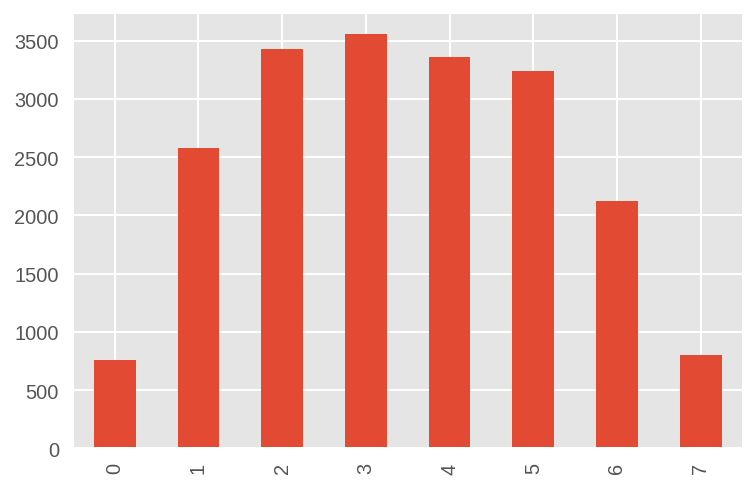

In [21]:
# Number of fixations per closest cue

fixations['closest_cue'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

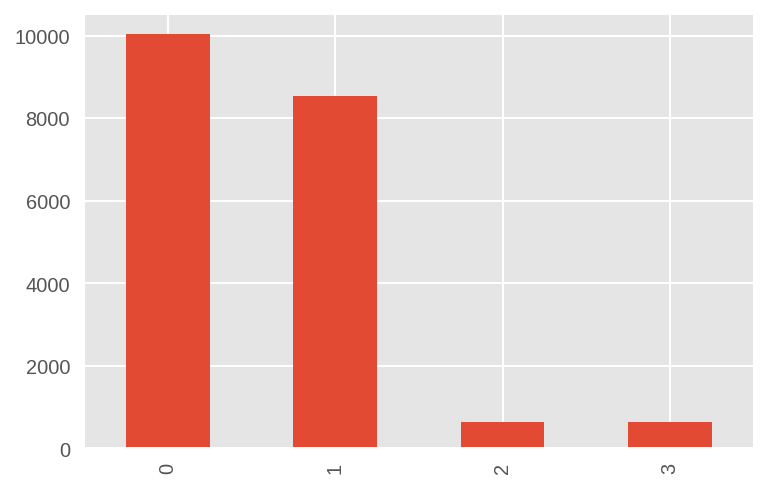

In [22]:
# Number of fixations in the time intervals

fixations['time_interval'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

### Fixations' location during visual pursuit

In [23]:
# Fixations for occlusion, cue vs no cue, left to right


ocl_fixations = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


onl_fixations = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


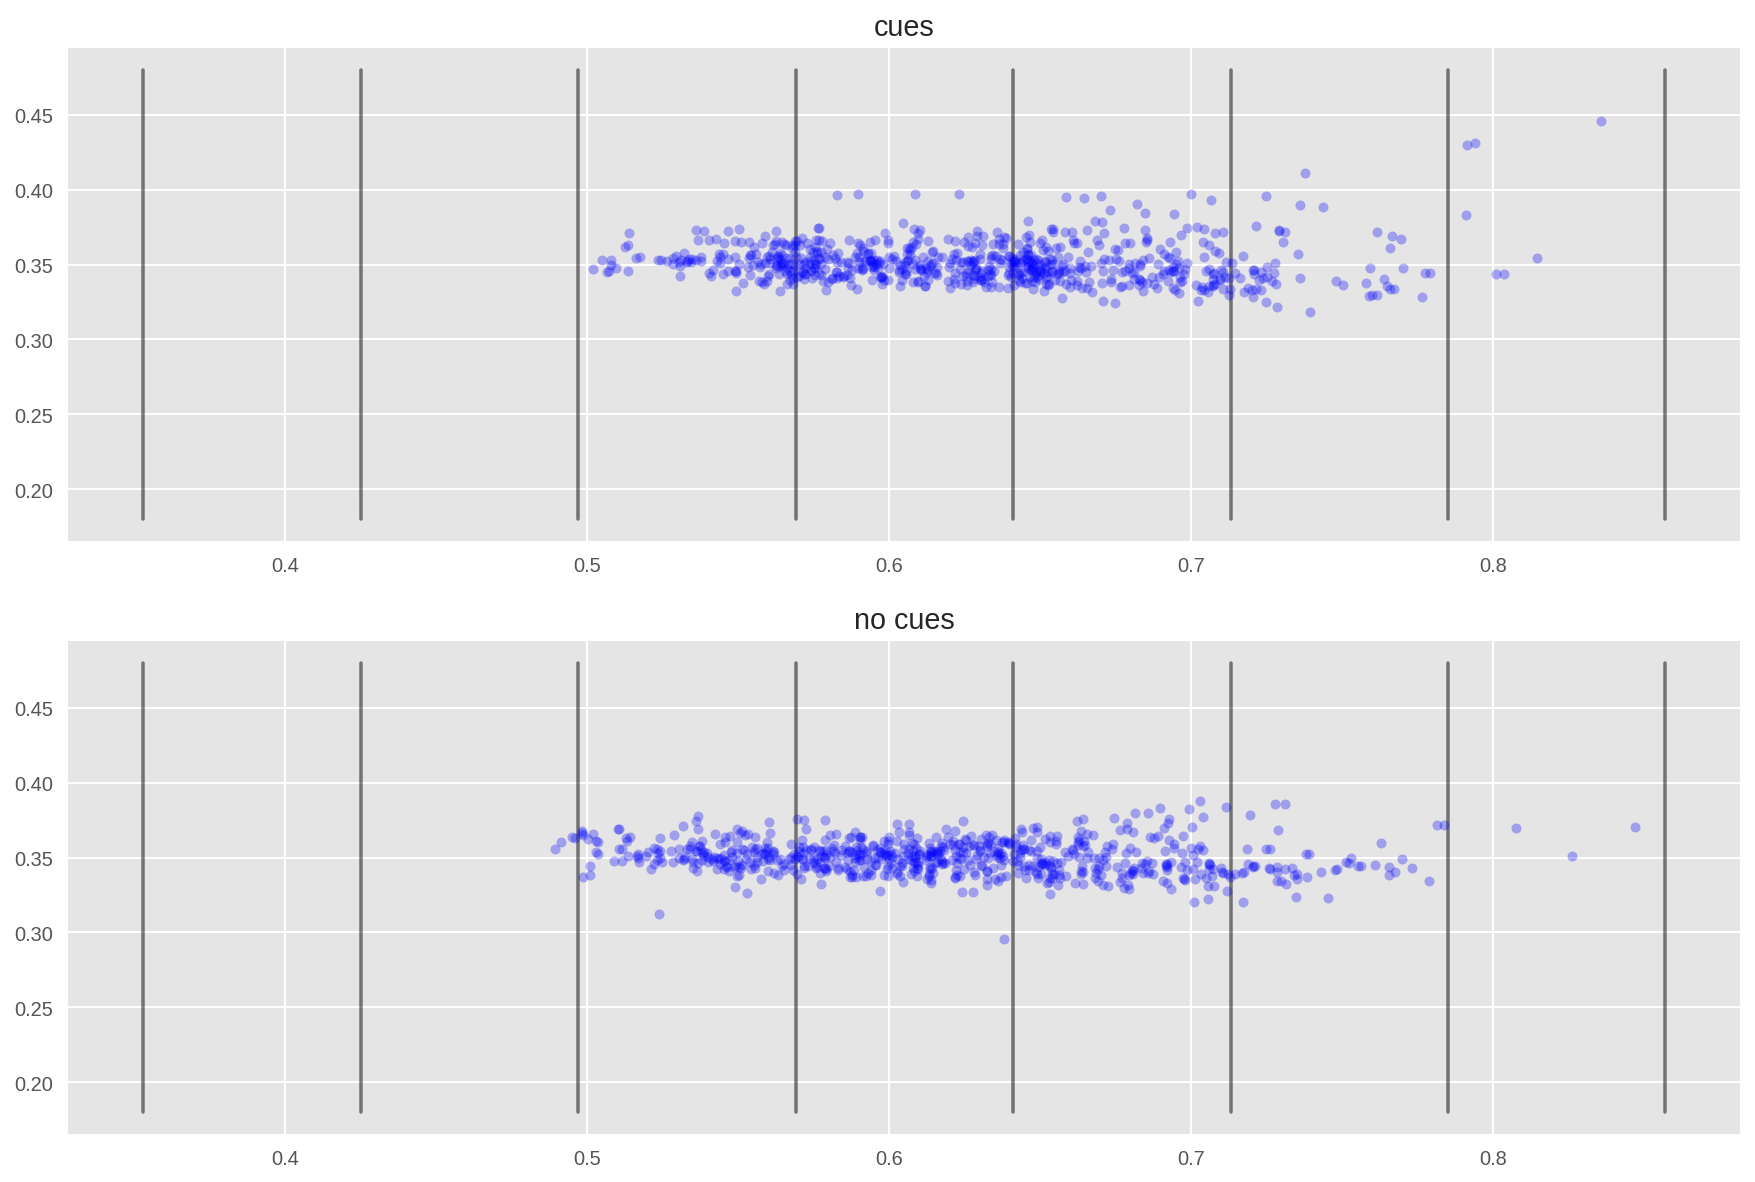

In [24]:
fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax1.set_title('cues')

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.plot(onl_fixations['centre_x'], onl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax2.set_title('no cues')

plt.show()


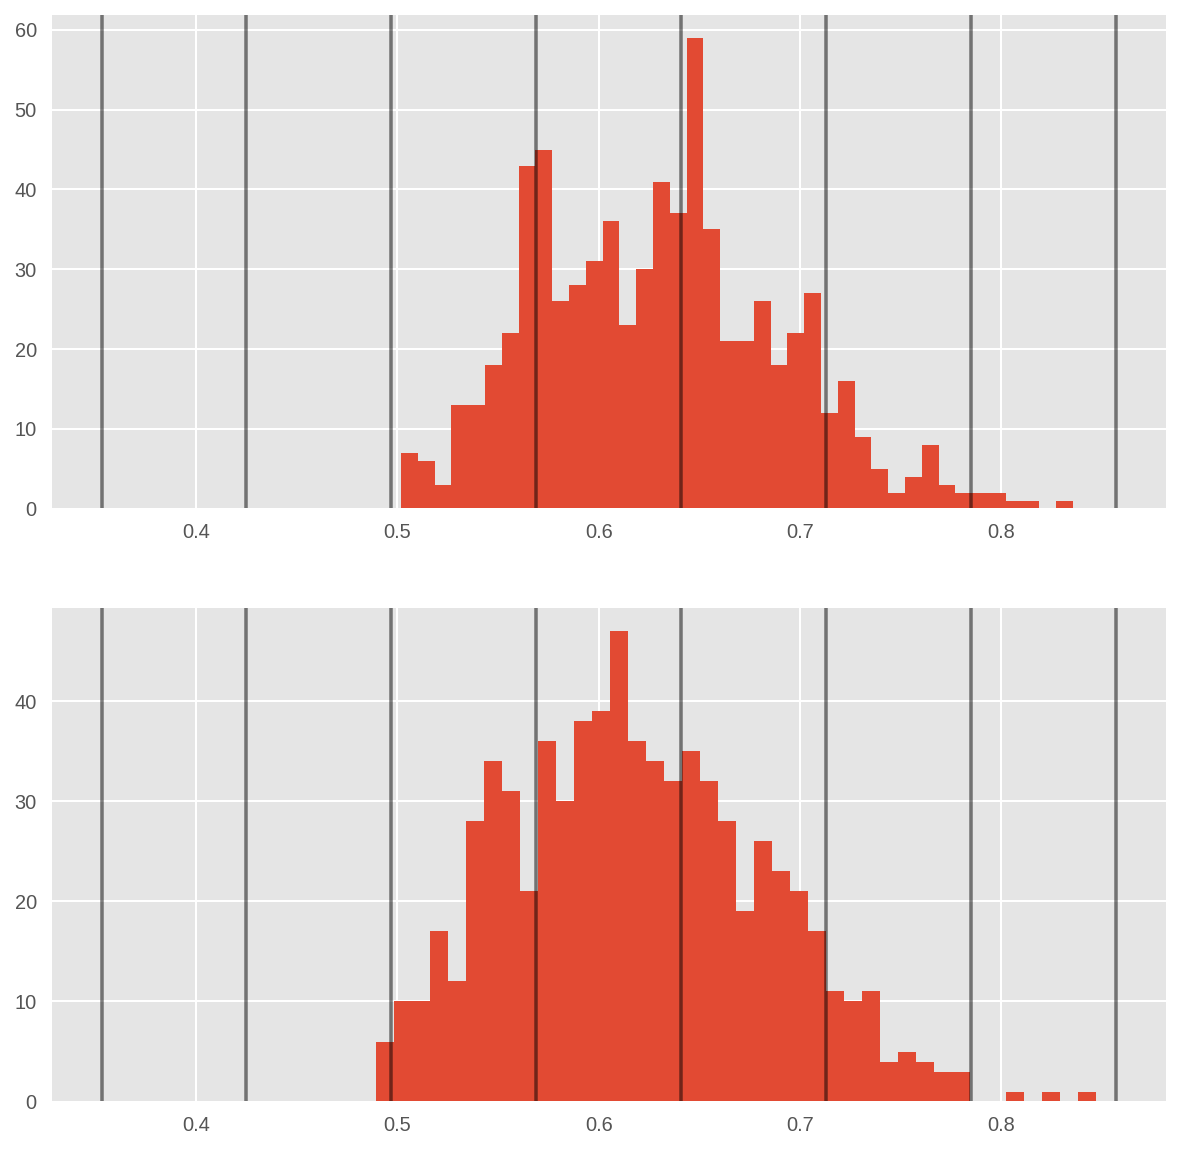

In [25]:
fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(ocl_fixations['centre_x'], bins = 40)
draw_cues(ax1)

ax2 = fig.add_subplot(212, sharex = ax1)
ax2.hist(onl_fixations['centre_x'], bins = 40)
draw_cues(ax2)

plt.show()

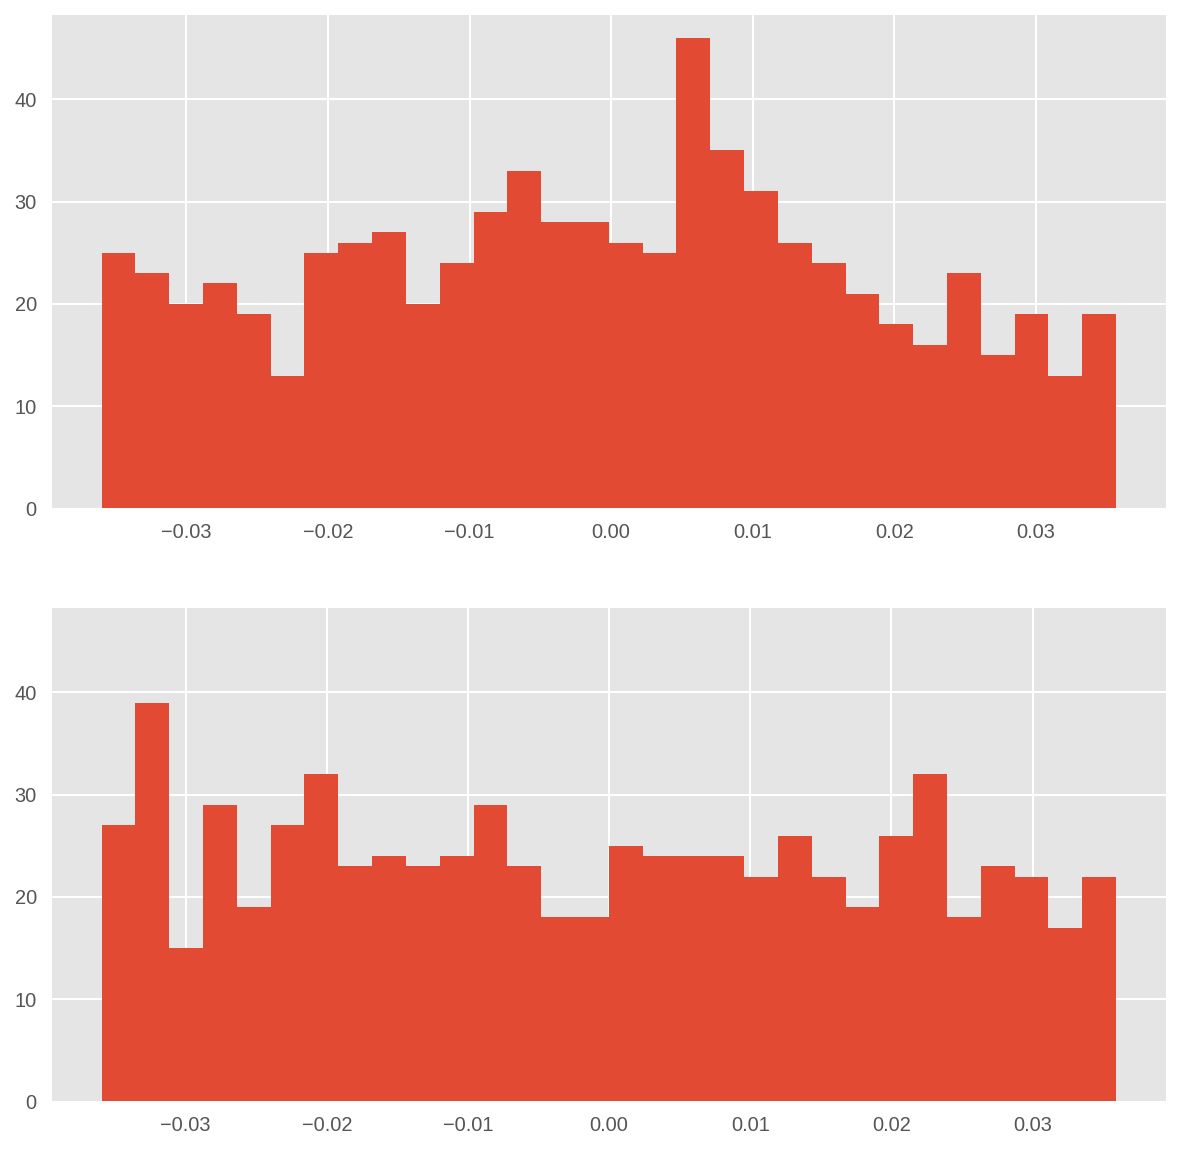

In [26]:
# Overlay the cues & plot the closest fixations. 0 = cue position

x1 = ocl_fixations['distance_to']
x2 = onl_fixations['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 30)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 30)
plt.show()

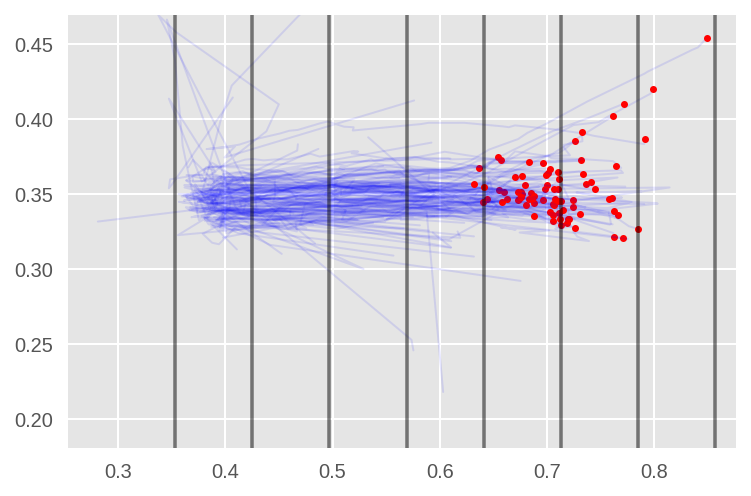

In [27]:

for subj in d.values():
    for trial in subj['trials'].values():
        if 'Occlusion_Cue_LeftToRight' in trial['name']:
            plt.plot(trial['fix']['centre_x'], trial['fix']['centre_z'], 'b-', alpha = 0.1, linewidth = 1)
            plt.plot(trial['fix']['centre_x'][-1], trial['fix']['centre_z'][-1], 'r.')

draw_cues(plt.gca(), ybottom = 0.18, ytop = 0.48)
plt.ylim(0.18, 0.47)
plt.show()

In [28]:
# Kolmogorov-Smirnov two-sample test for ocl vs onl

res = ks_2samp(x1, x2)
print 'ks = {}\np = {}'.format(round(res[0], 4), round(res[1], 4))

ks = 0.0625
p = 0.1164


### Fixations at the reach onset
- select the cue/nocue condition and the third time interval
- group by participant and trial id
- grab the first fixation's x and z coordinates
- merge the distance from gaze @ reach onset from the accuracies table

In [29]:
fix_ro_ocl = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & (fixations['time_interval'] == 3)] \
                    .groupby(['trial', 'p'])[['centre_x', 'centre_z']] \
                    .apply(lambda x: x.iloc[0]) \
                    .reset_index()
fix_ro_ocl = pd.merge(fix_ro_ocl, accuracies[['p', 'trial', 'eyes_object_ro']], on = ['p', 'trial'])

fix_ro_onl = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & (fixations['time_interval'] == 3)] \
                    .groupby(['trial', 'p'])[['centre_x', 'centre_z']] \
                    .apply(lambda x: x.iloc[0]) \
                    .reset_index()
fix_ro_onl = pd.merge(fix_ro_onl, accuracies[['p', 'trial', 'eyes_object_ro']], on = ['p', 'trial'])

fix_ro_onl.head()

trial    p  centre_x  centre_z  eyes_object_ro
0   t13  P07  0.759230  0.354232        0.008044
1   t13  P08  0.713094  0.342430       -0.042591
2   t13  P12  0.675443  0.349682       -0.034145
3   t13  P16  0.775413  0.334699       -0.007337
4   t13  P18  0.685553  0.364964       -0.098069

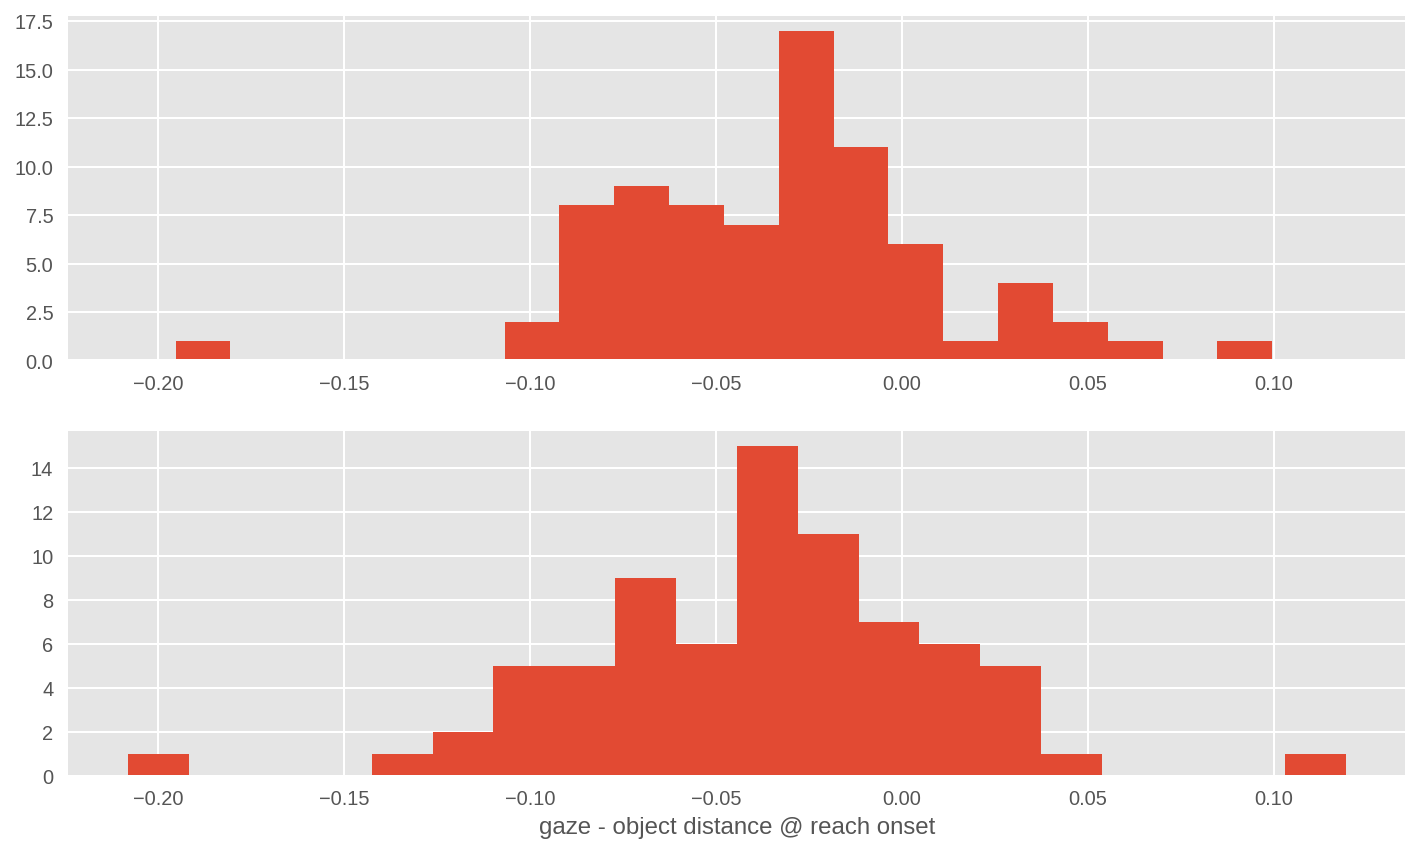

In [30]:
# Distribution of fixation-object distances at the reach onset

fig = plt.figure(figsize = (12, 7))

ax1 = fig.add_subplot(211)
ax1.hist(fix_ro_ocl['eyes_object_ro'], bins = 20)

ax2 = fig.add_subplot(212, sharex = ax1)
ax2.hist(fix_ro_onl['eyes_object_ro'], bins = 20)
ax2.set_xlabel('gaze - object distance @ reach onset')

plt.show()

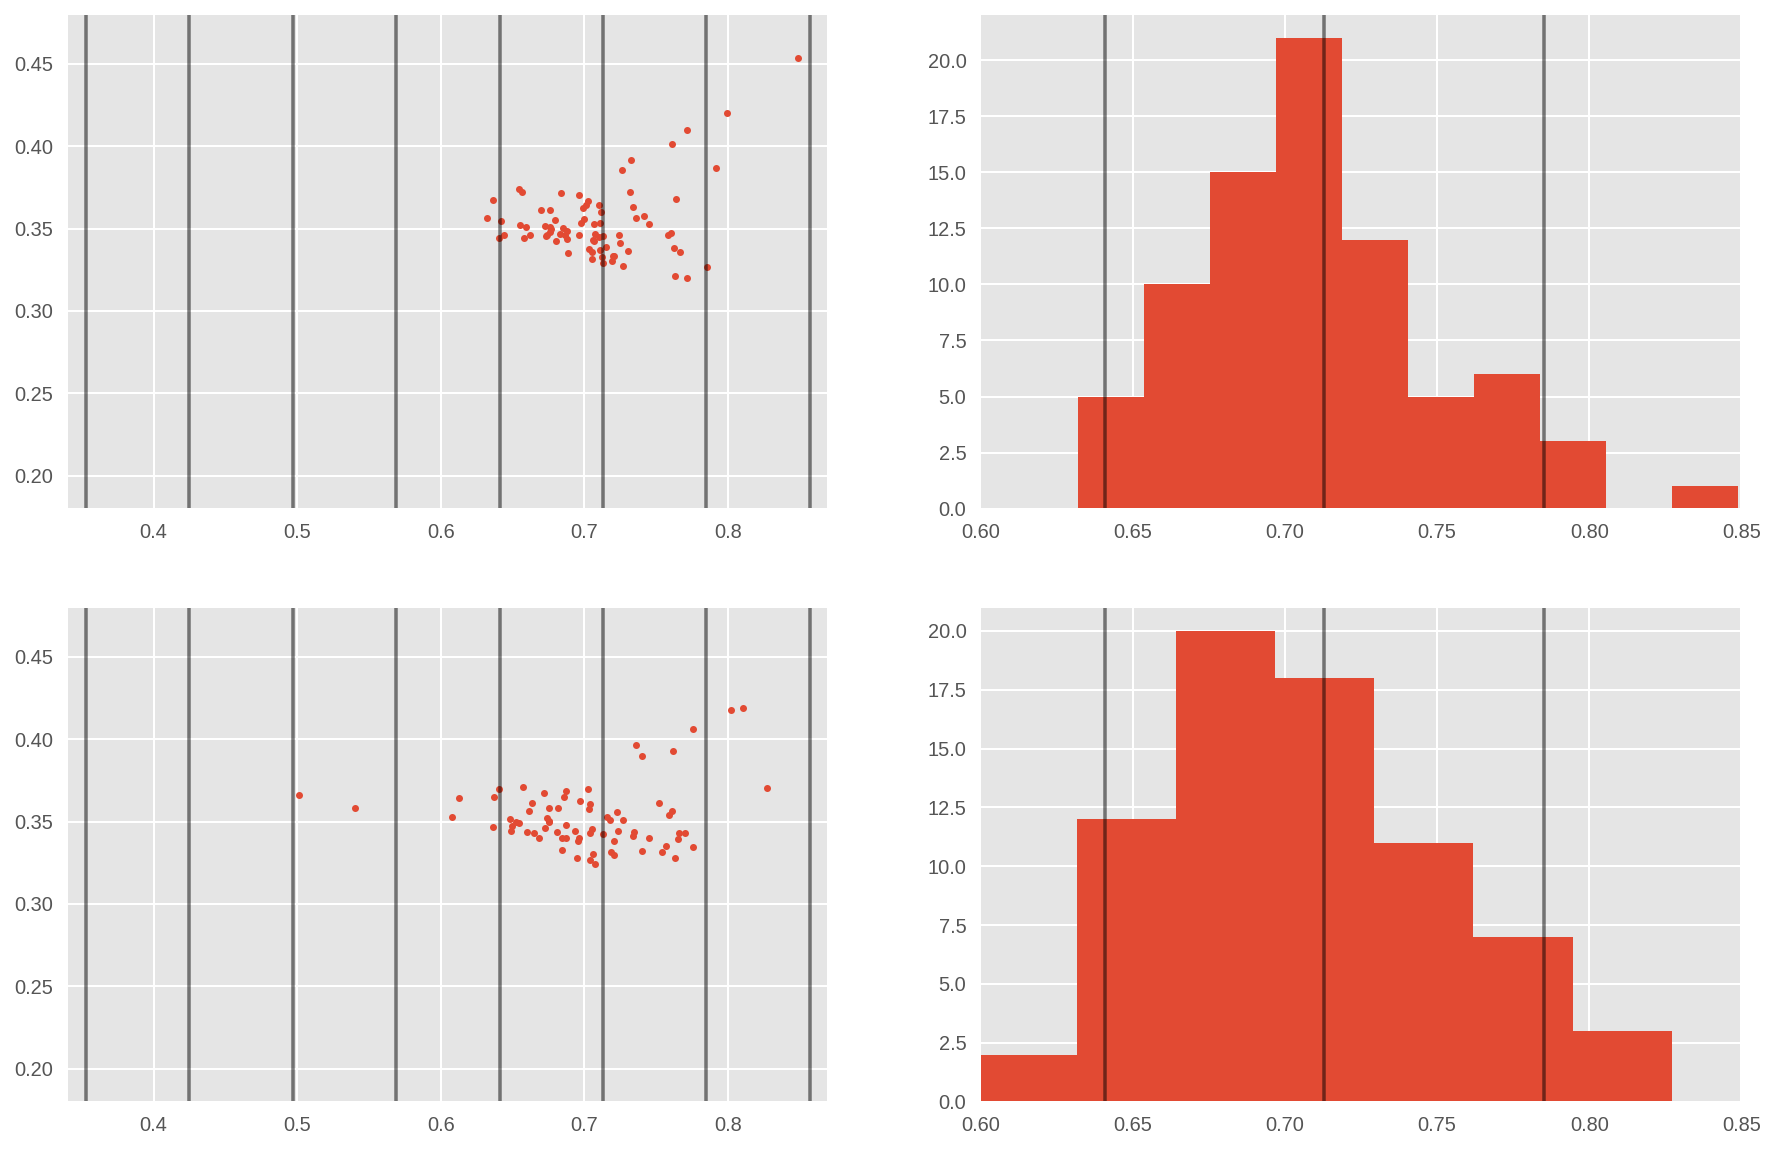

In [31]:
# Fixations at the reach onset relative to the screen

fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(221)
ax1.plot(fix_ro_ocl.centre_x, fix_ro_ocl.centre_z, '.')
ax1.set_xlim(0.34, 0.87)
ax1.set_ylim(0.18, 0.48)
draw_cues(ax1)

ax2 = fig.add_subplot(222)
ax2.hist(fix_ro_ocl.centre_x)
draw_cues(ax2)
ax2.set_xlim(0.6, 0.85)

ax3 = fig.add_subplot(223)
ax3.plot(fix_ro_onl.centre_x, fix_ro_onl.centre_z, '.')
ax3.set_xlim(0.34, 0.87)
ax3.set_ylim(0.18, 0.48)
draw_cues(ax3)

ax4 = fig.add_subplot(224, sharex = ax2)
ax4.hist(fix_ro_onl.centre_x)
draw_cues(ax4)
ax4.set_xlim(0.6, 0.85)

plt.show()

### Fixations' location during reach

In [32]:
ocl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

ocl_fix_final = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]


onl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

onl_fix_final = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]

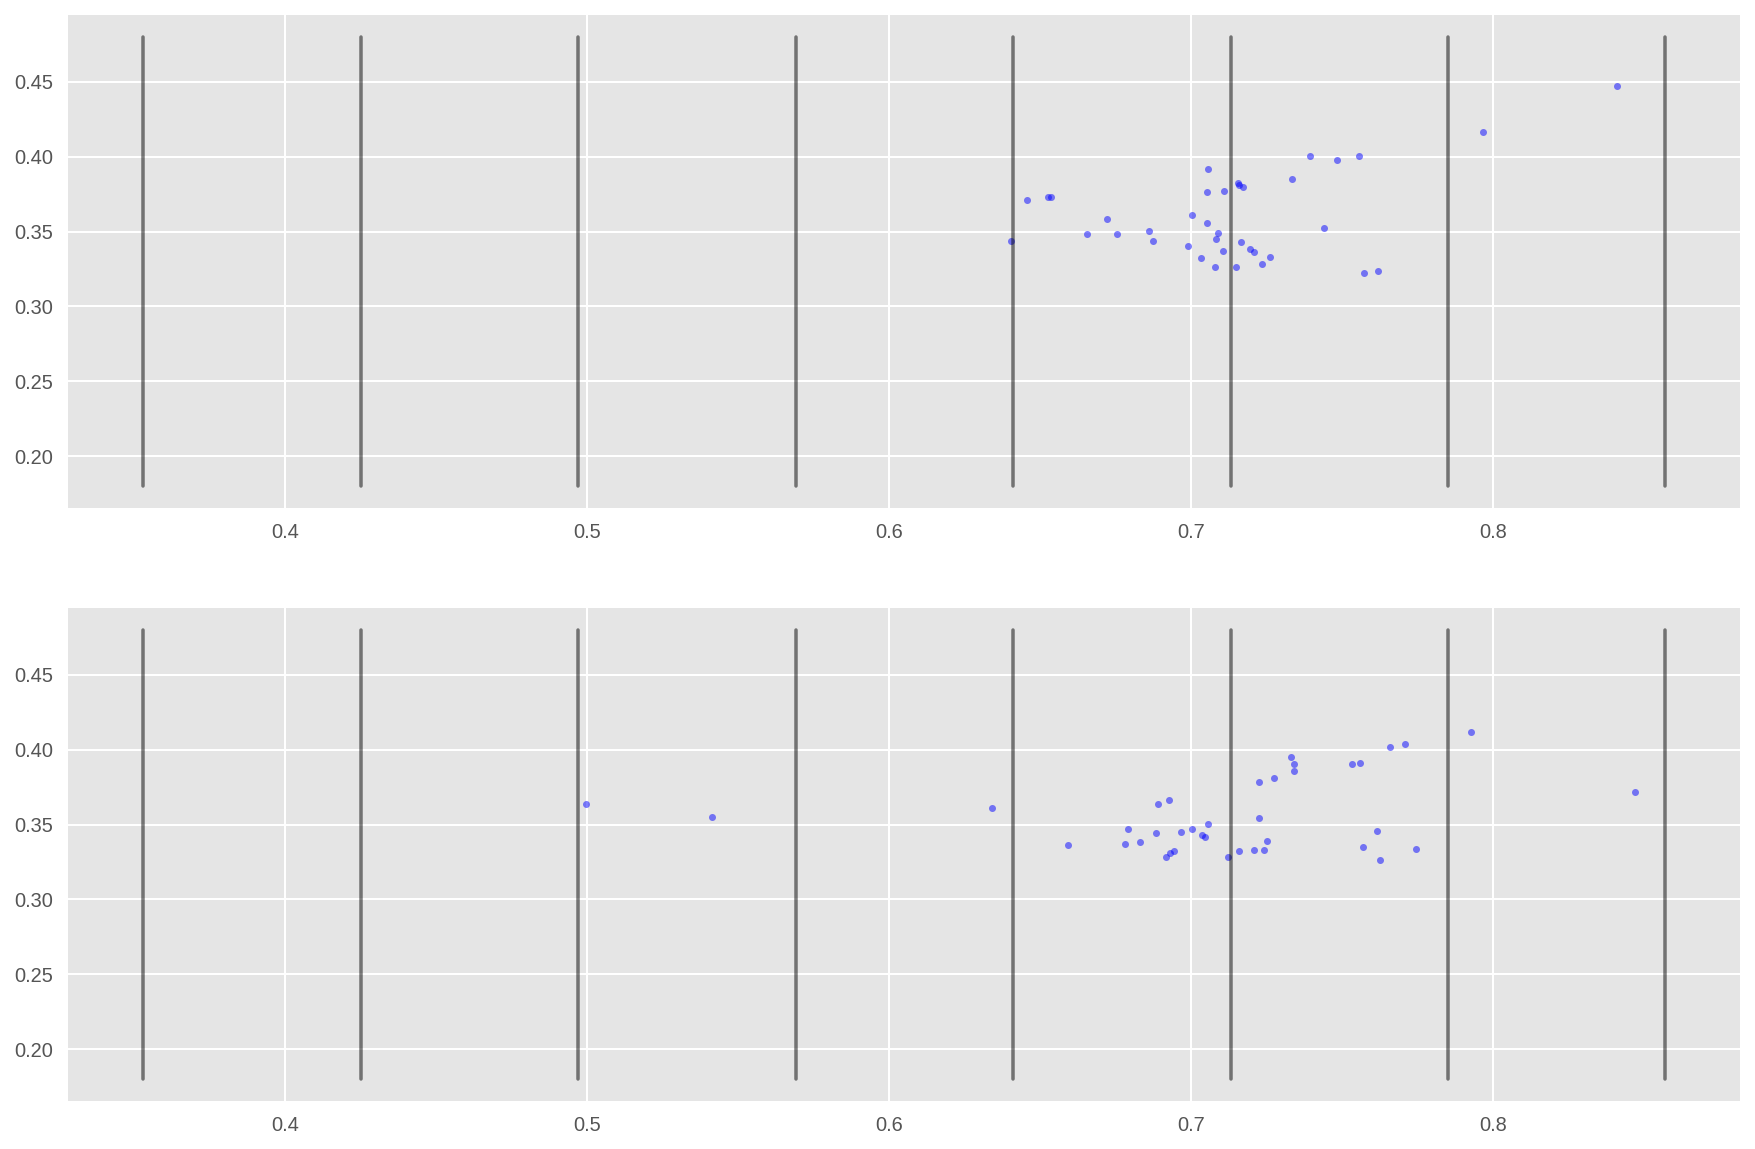

In [33]:
# Fixations after the reach onset

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fix_reach['centre_x'], ocl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.set_xlim(0.34, 0.87)
ax1.set_ylim(0.18, 0.48)

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fix_reach['centre_x'], onl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)

plt.show()

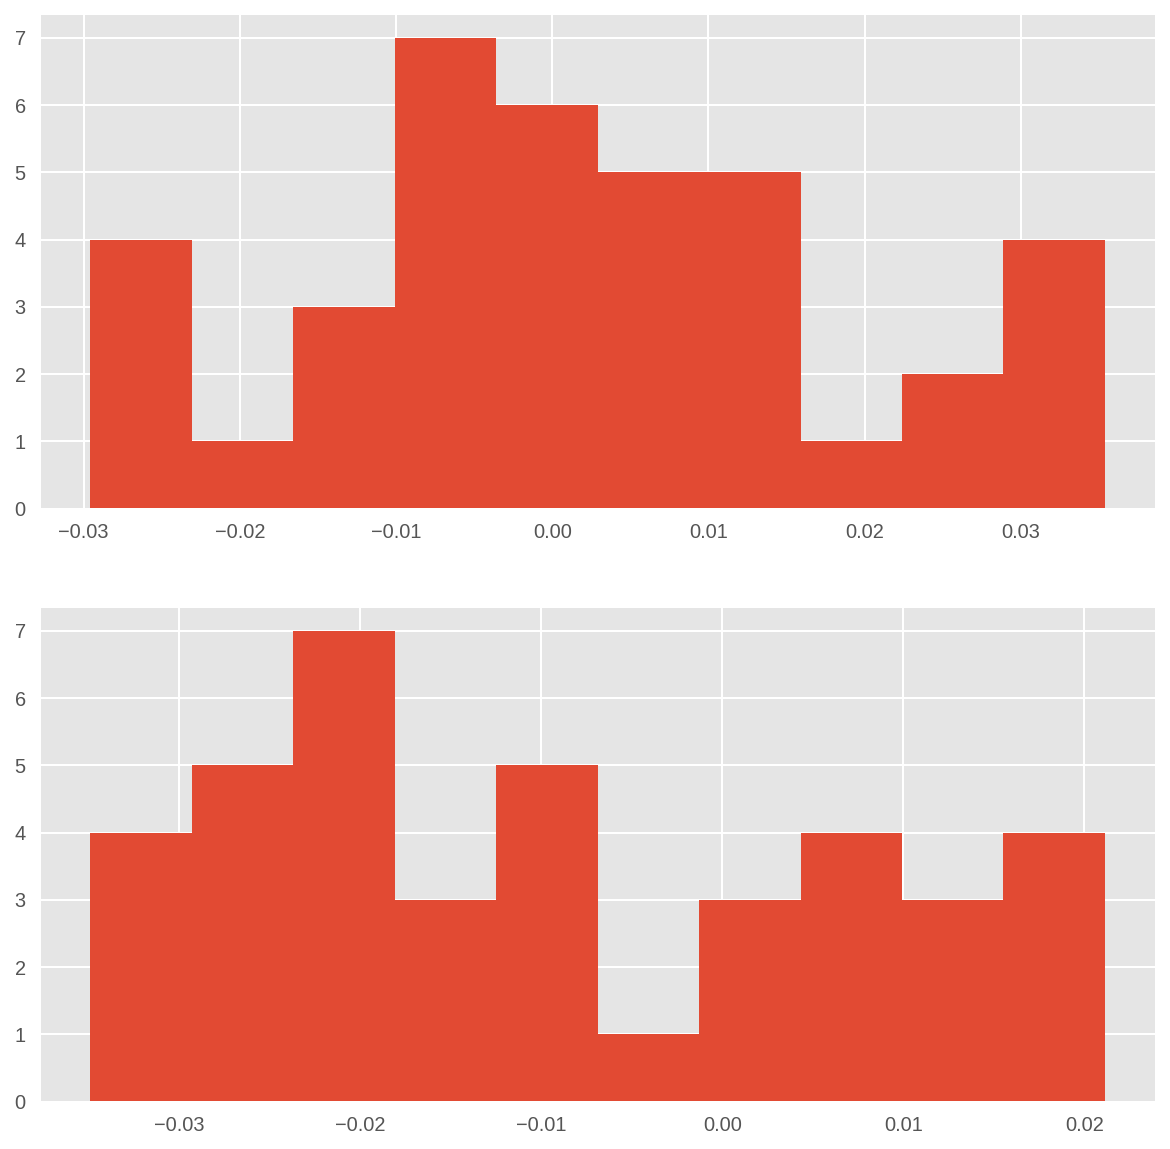

In [34]:
# Distribution relative to the cue

x1 = ocl_fix_reach['distance_to']
x2 = onl_fix_reach['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 10)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 10)
plt.show()

### Fixations' duration

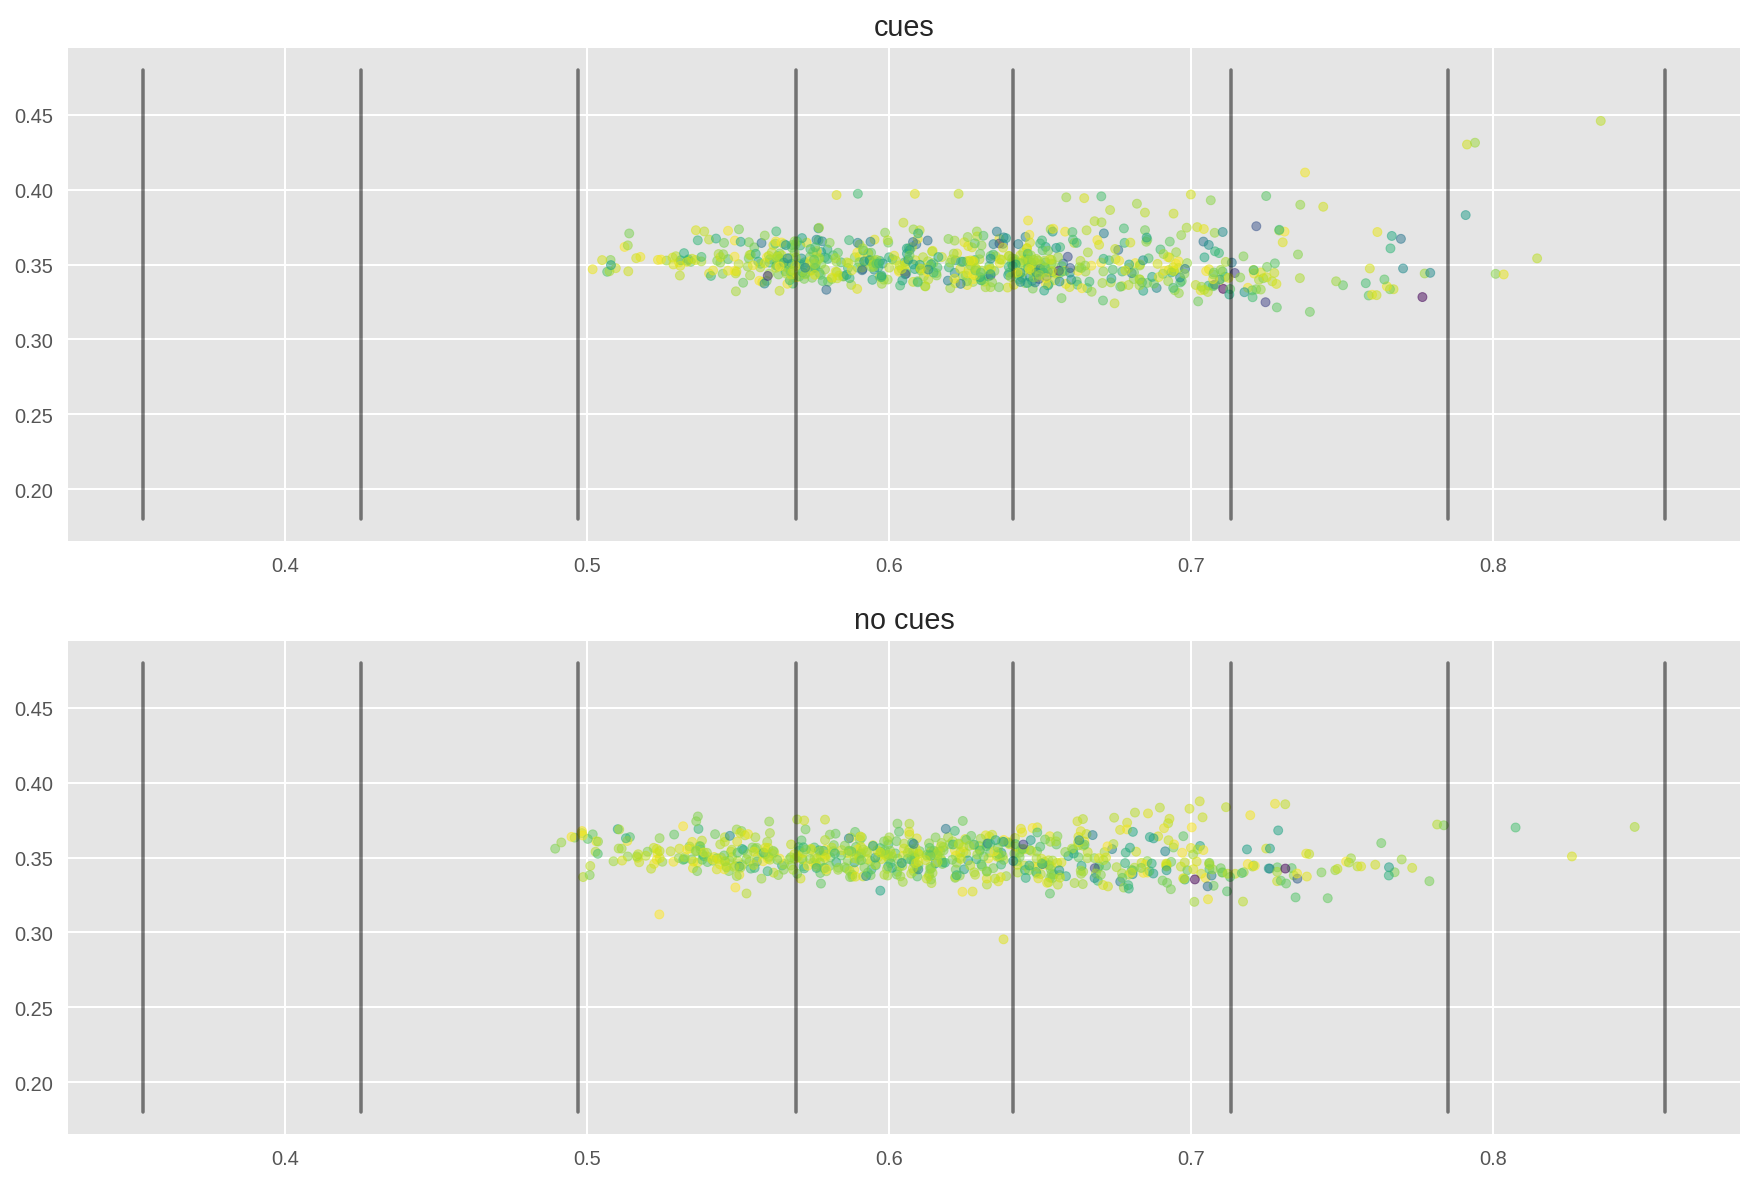

In [35]:
from matplotlib import cm

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['centre_z'], c = ocl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax1.set_title('cues')
# ax1.set_xlim(0.5, 0.8)
# ax1.set_ylim(0.3, 0.4)

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['centre_z'], c = onl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax2.set_title('no cues')

plt.show()

r = -0.075
p = 0.045


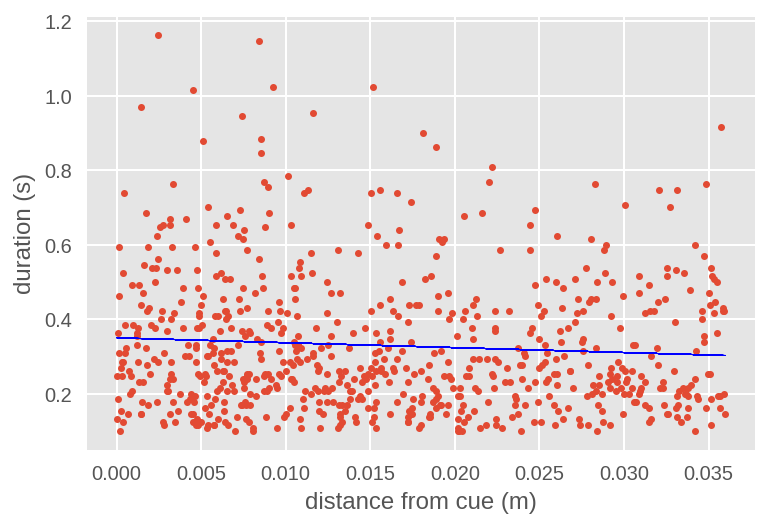

In [36]:
# Linear model duration ~ distance for ocl

from scipy.stats import linregress

slope, intercept, r, p, stderr = linregress(abs(ocl_fixations['distance_to']), ocl_fixations['duration'])
print 'r = {}\np = {}'.format(round(r, 3), round(p, 3))
y = slope * abs(ocl_fixations['distance_to']) + intercept

plt.plot(abs(ocl_fixations['distance_to']), ocl_fixations['duration'], '.')
plt.plot(abs(ocl_fixations['distance_to']), y, 'b-', linewidth = 0.5)
plt.xlabel('distance from cue (m)')
plt.ylabel('duration (s)')
plt.show()

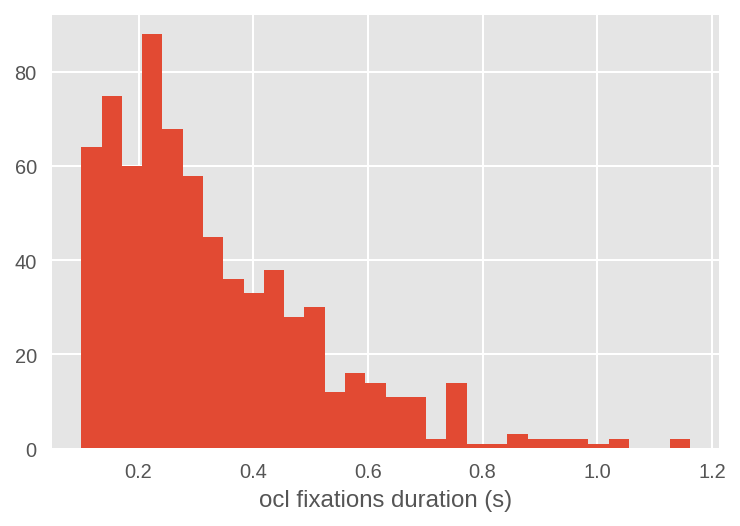

In [37]:
# Distribution of fixations' duration

plt.hist(ocl_fixations['duration'], bins = 30)
plt.xlabel('ocl fixations duration (s)')
plt.show()

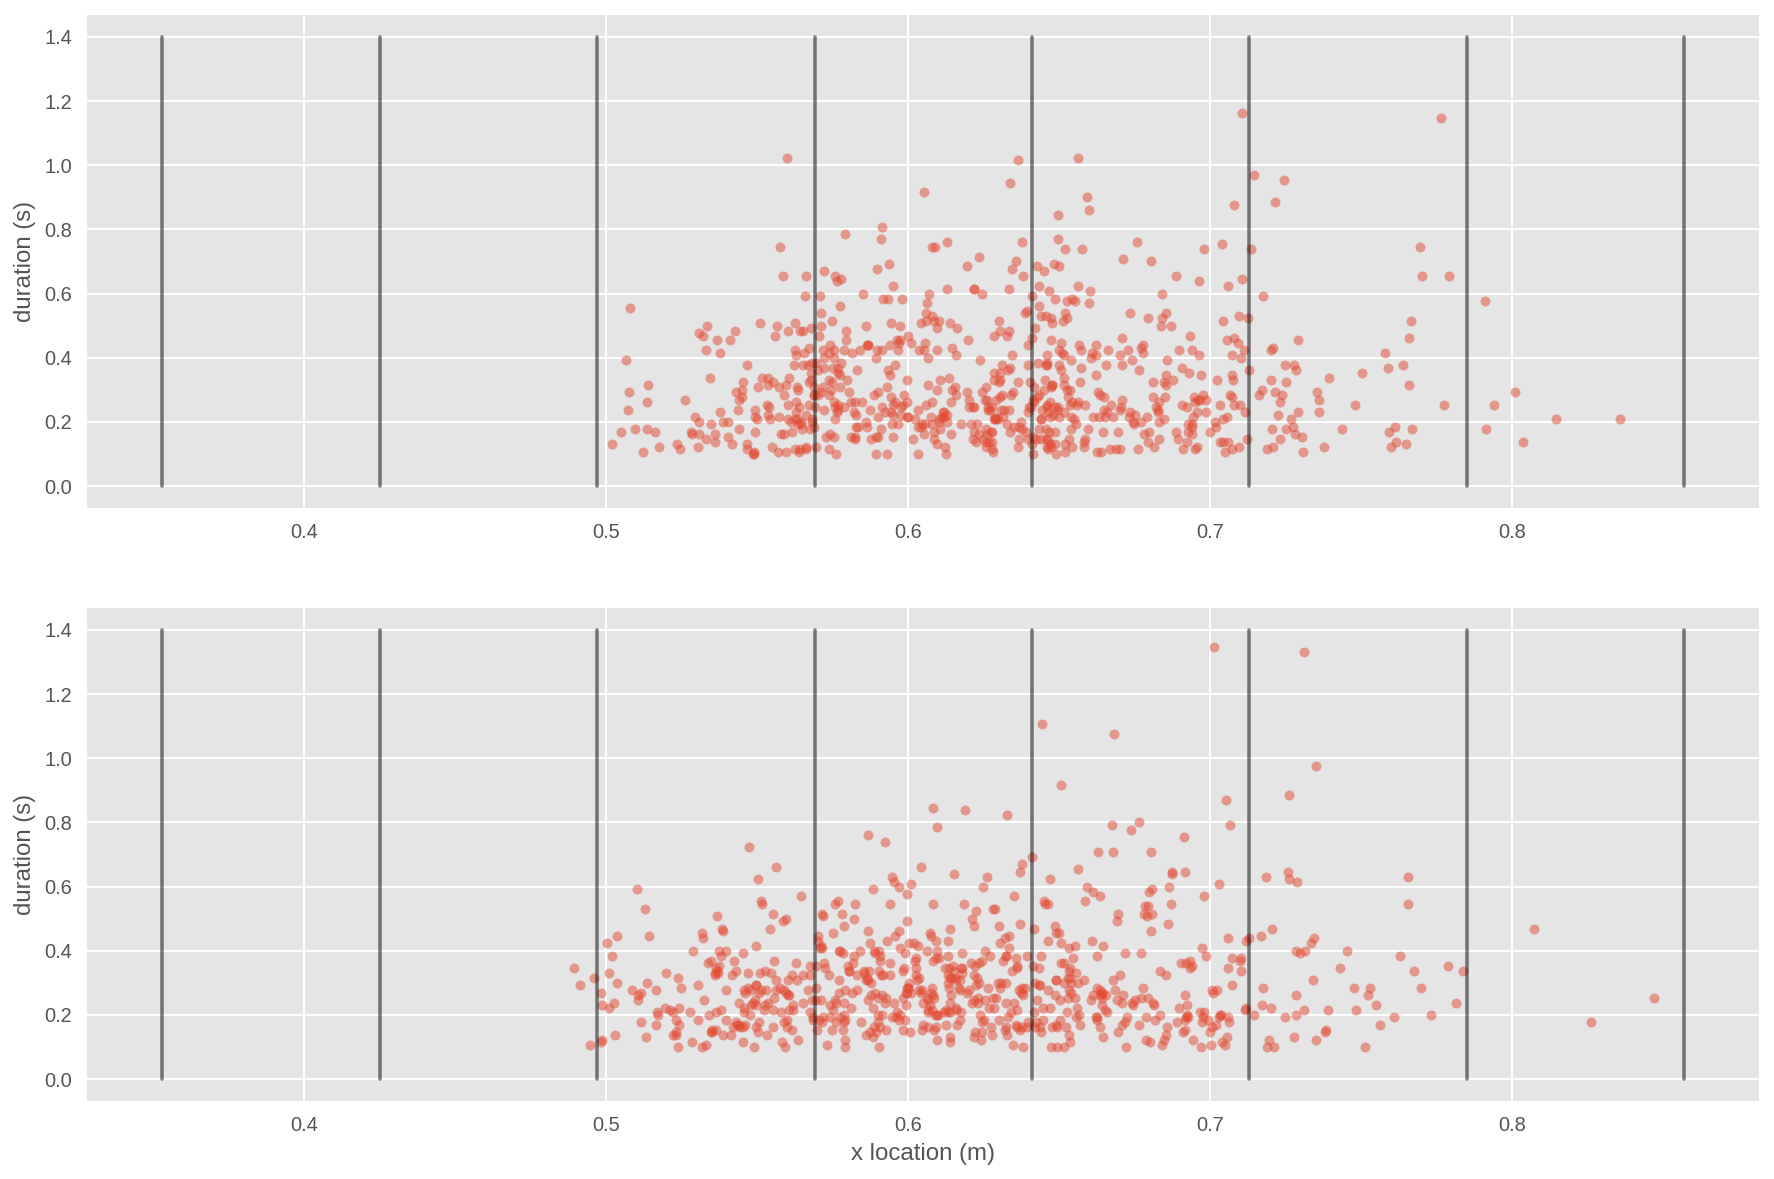

In [38]:
# Fixation duration against location on the x-axis

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fixations['centre_x'], onl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

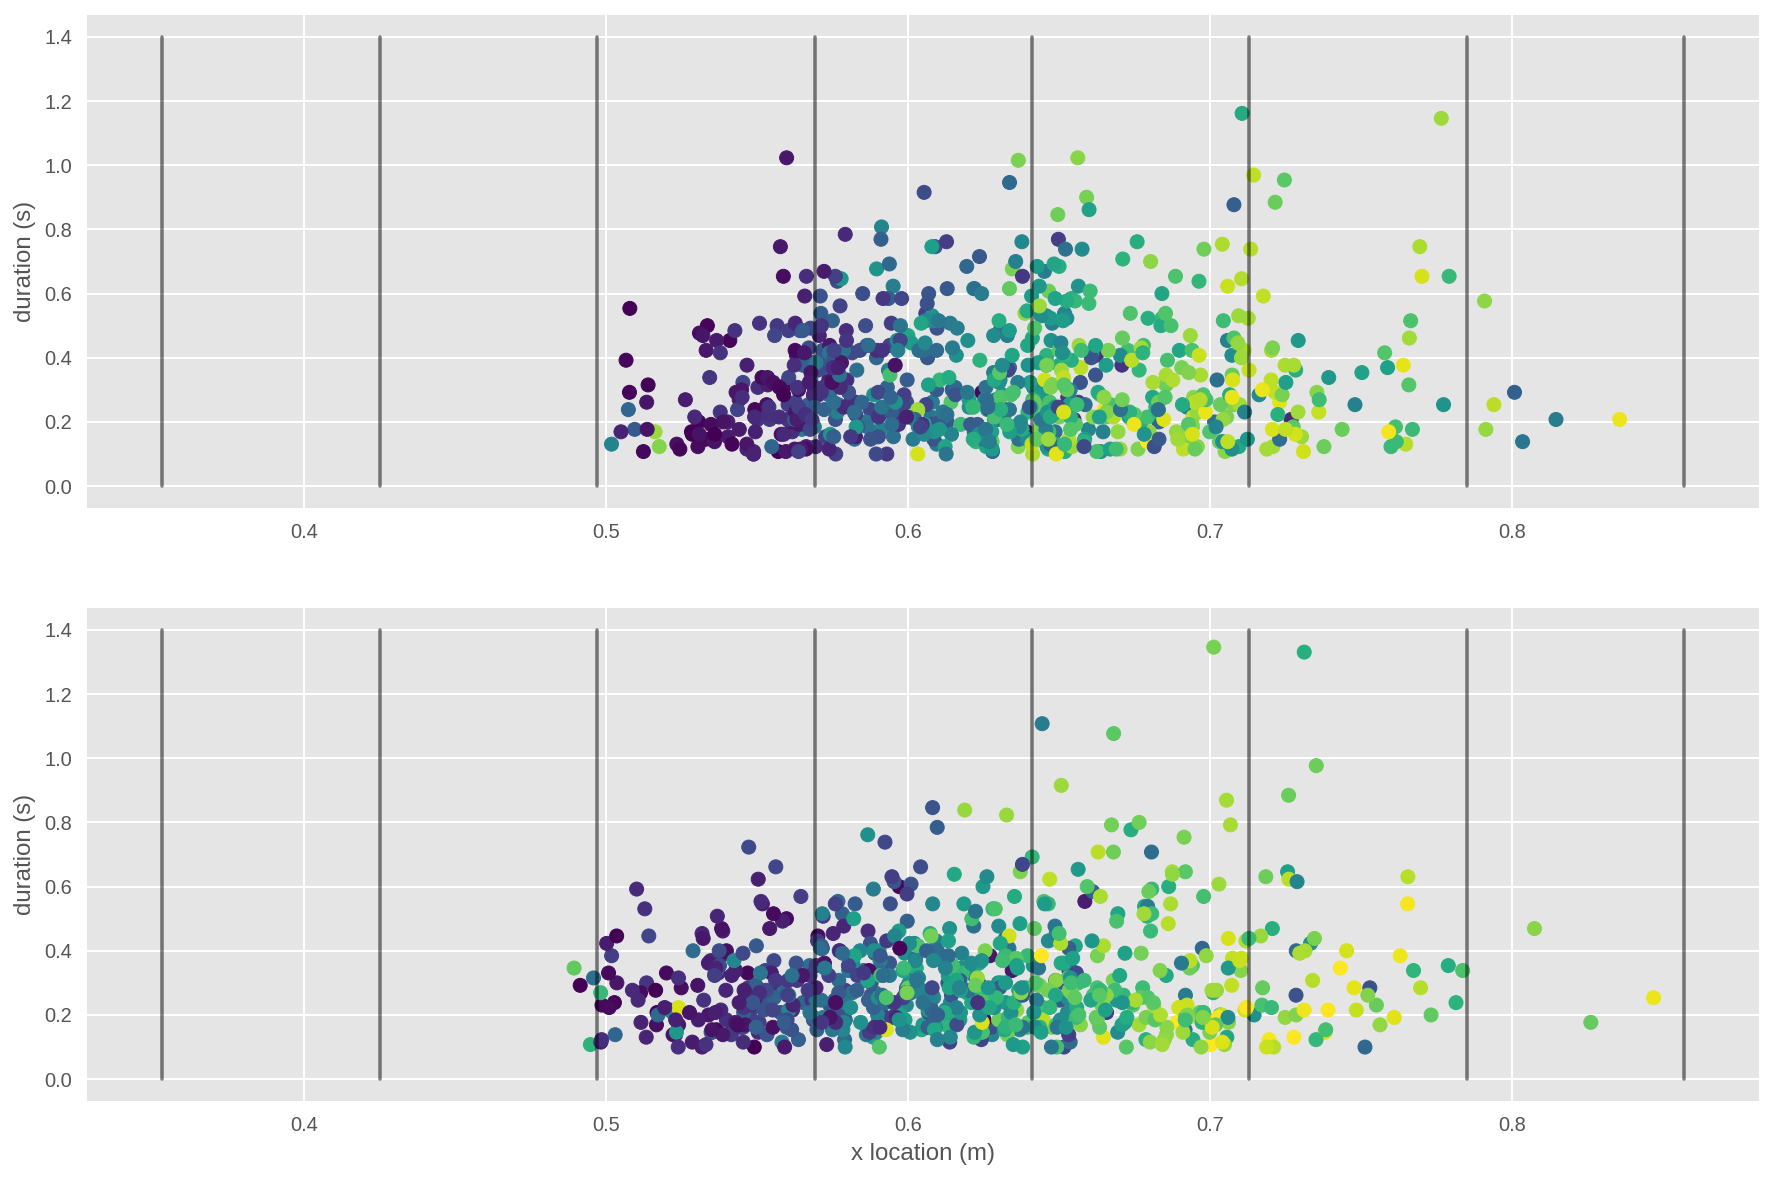

In [39]:
fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['duration'], c = ocl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['duration'], c = onl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

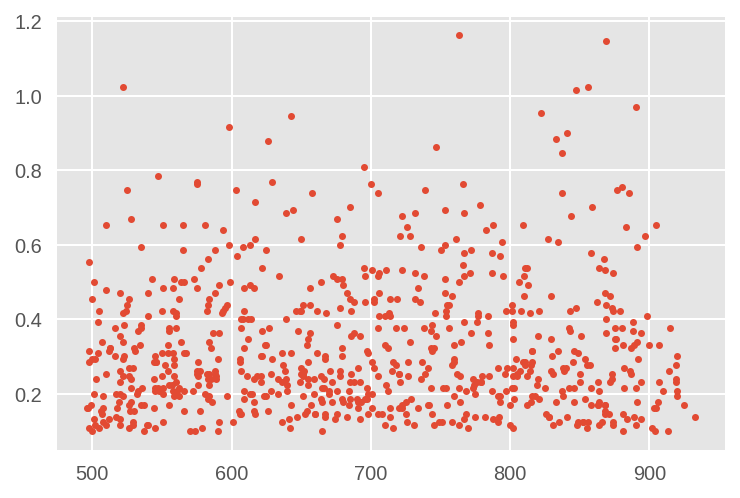

In [40]:
plt.plot(ocl_fixations['start_frame'], ocl_fixations['duration'], '.')
plt.show()

## Reaching movement

In [41]:
def auc(x, y, z):
    vel = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) # in m/frame. divide by sampling freq to get m/s
    d = sum(vel)
    return d

In [42]:
# Find the reach travel distance for wrist

td = pd.DataFrame(columns = ['participant', 'condition', 'travel_distance'])

for pid, subj in d.items():
    for trial in subj['trials'].values():
        
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        z = trial[markers[pid]['wrist'] + 'z']
        
        dist = auc(x, y, z)
        cond = trial['name'][6:-4]
        
        to_add = pd.Series([pid, cond, dist], td.columns.values.tolist())
        td = td.append(to_add, ignore_index = True)
        
td[:5]

participant                  condition  travel_distance
0         P16  Visible_NoCue_RightToLeft         0.428054
1         P16  Visible_NoCue_LeftToRight         0.314738
2         P16  Visible_NoCue_LeftToRight         0.314468
3         P16  Visible_NoCue_RightToLeft         0.467652
4         P16  Visible_NoCue_RightToLeft         0.420237

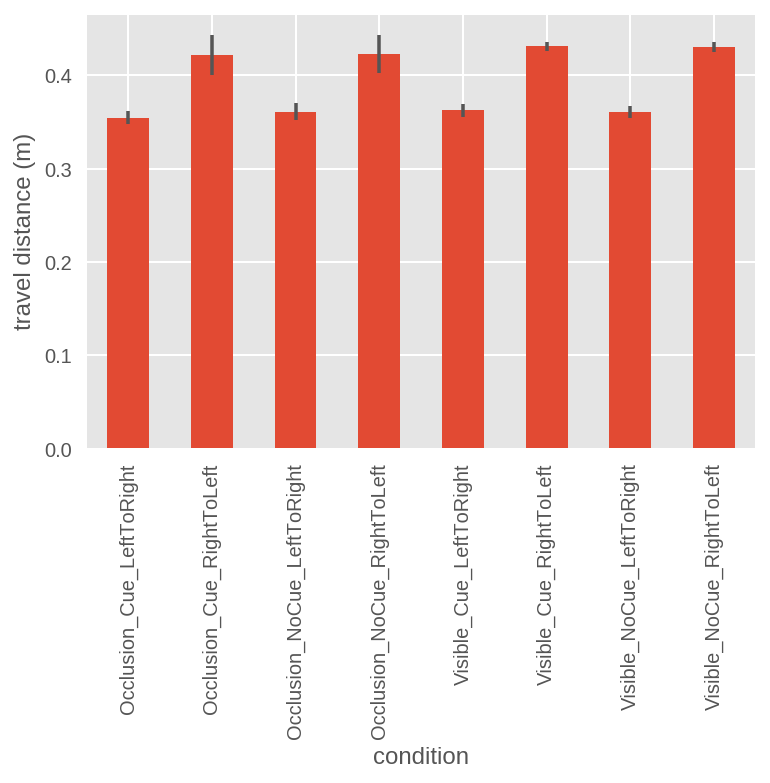

In [43]:
a = td.groupby(['participant', 'condition']).aggregate(np.mean).reset_index()
b = a.pivot(index = 'participant', columns = 'condition', values = 'travel_distance')
c = b.mean(axis = 0)
# b.loc[:, ['Occlusion_Cue_LeftToRight', 'Visible_Cue_LeftToRight']].plot(kind = 'bar')
c.plot(kind = 'bar',  yerr = b.std(axis = 0) / np.sqrt(len(b)))
plt.ylabel('travel distance (m)')
plt.show()

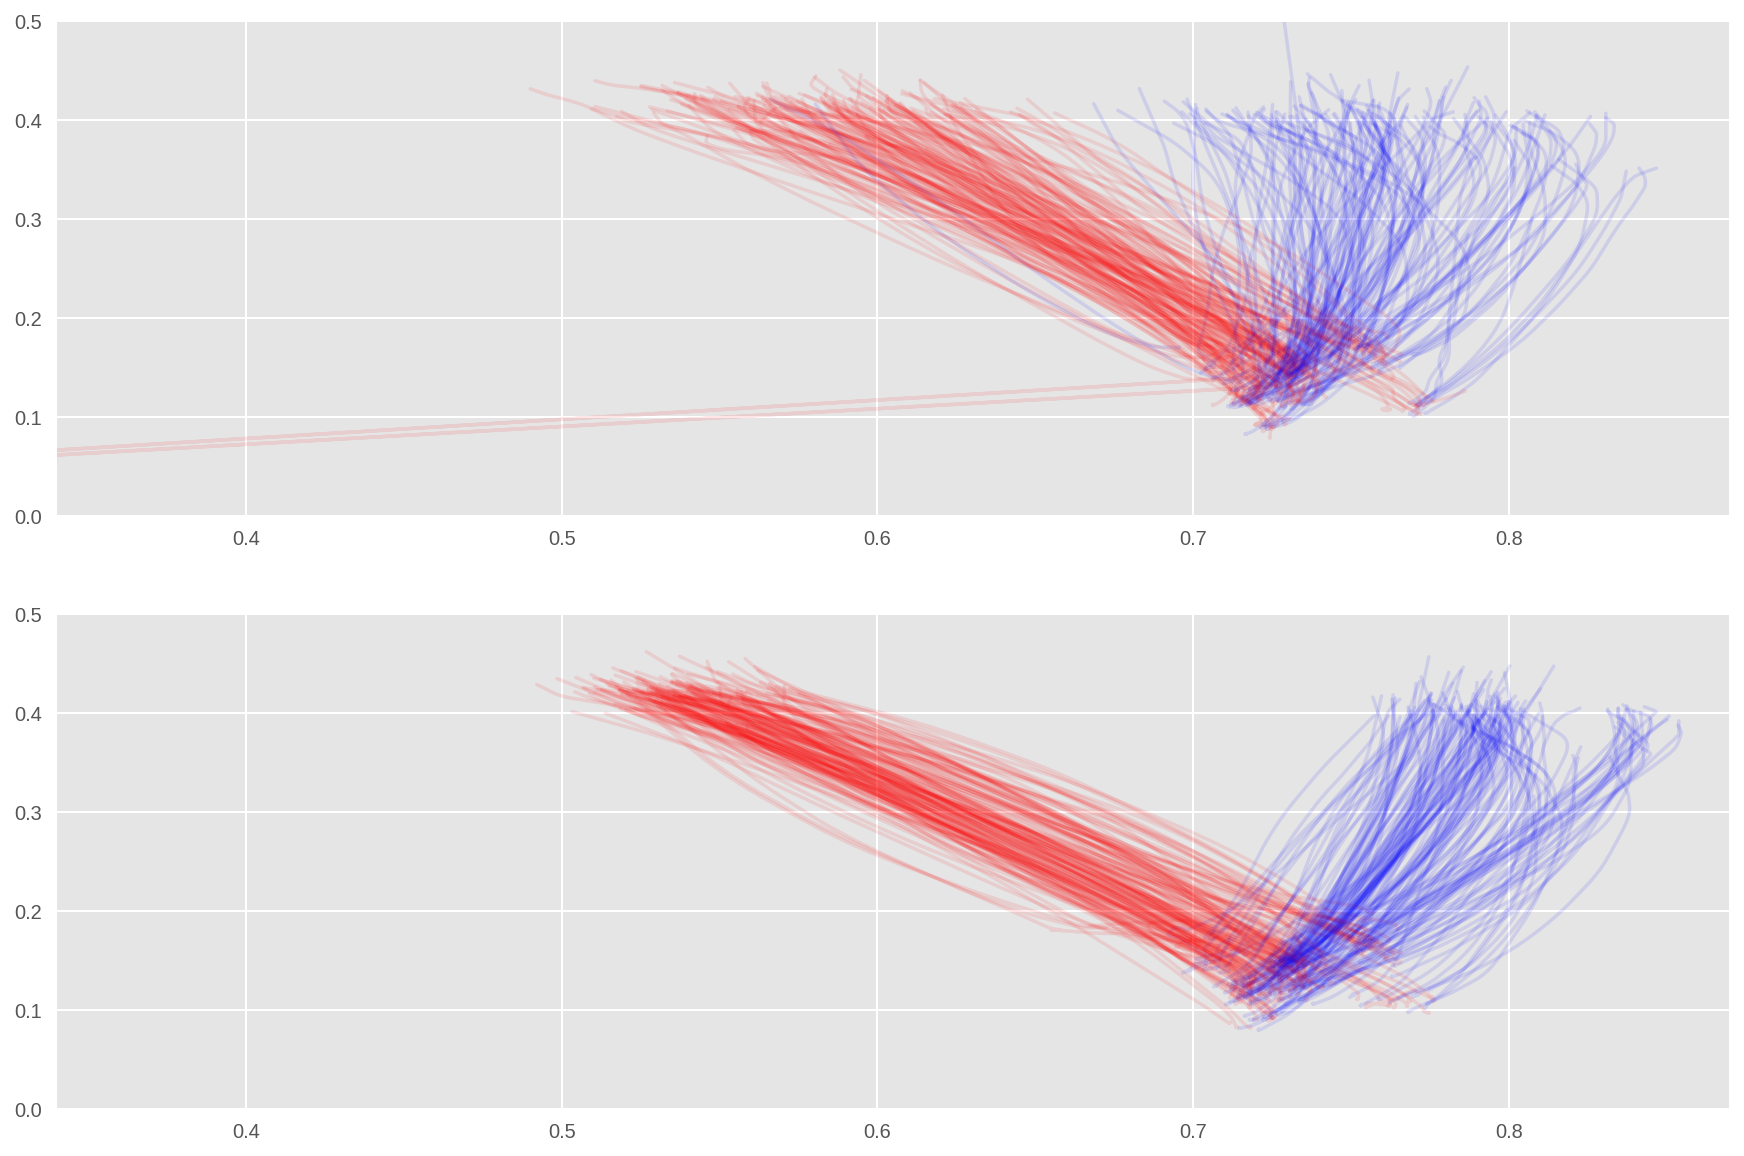

In [44]:
# Reach trajectories on x-y axes for wrist

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

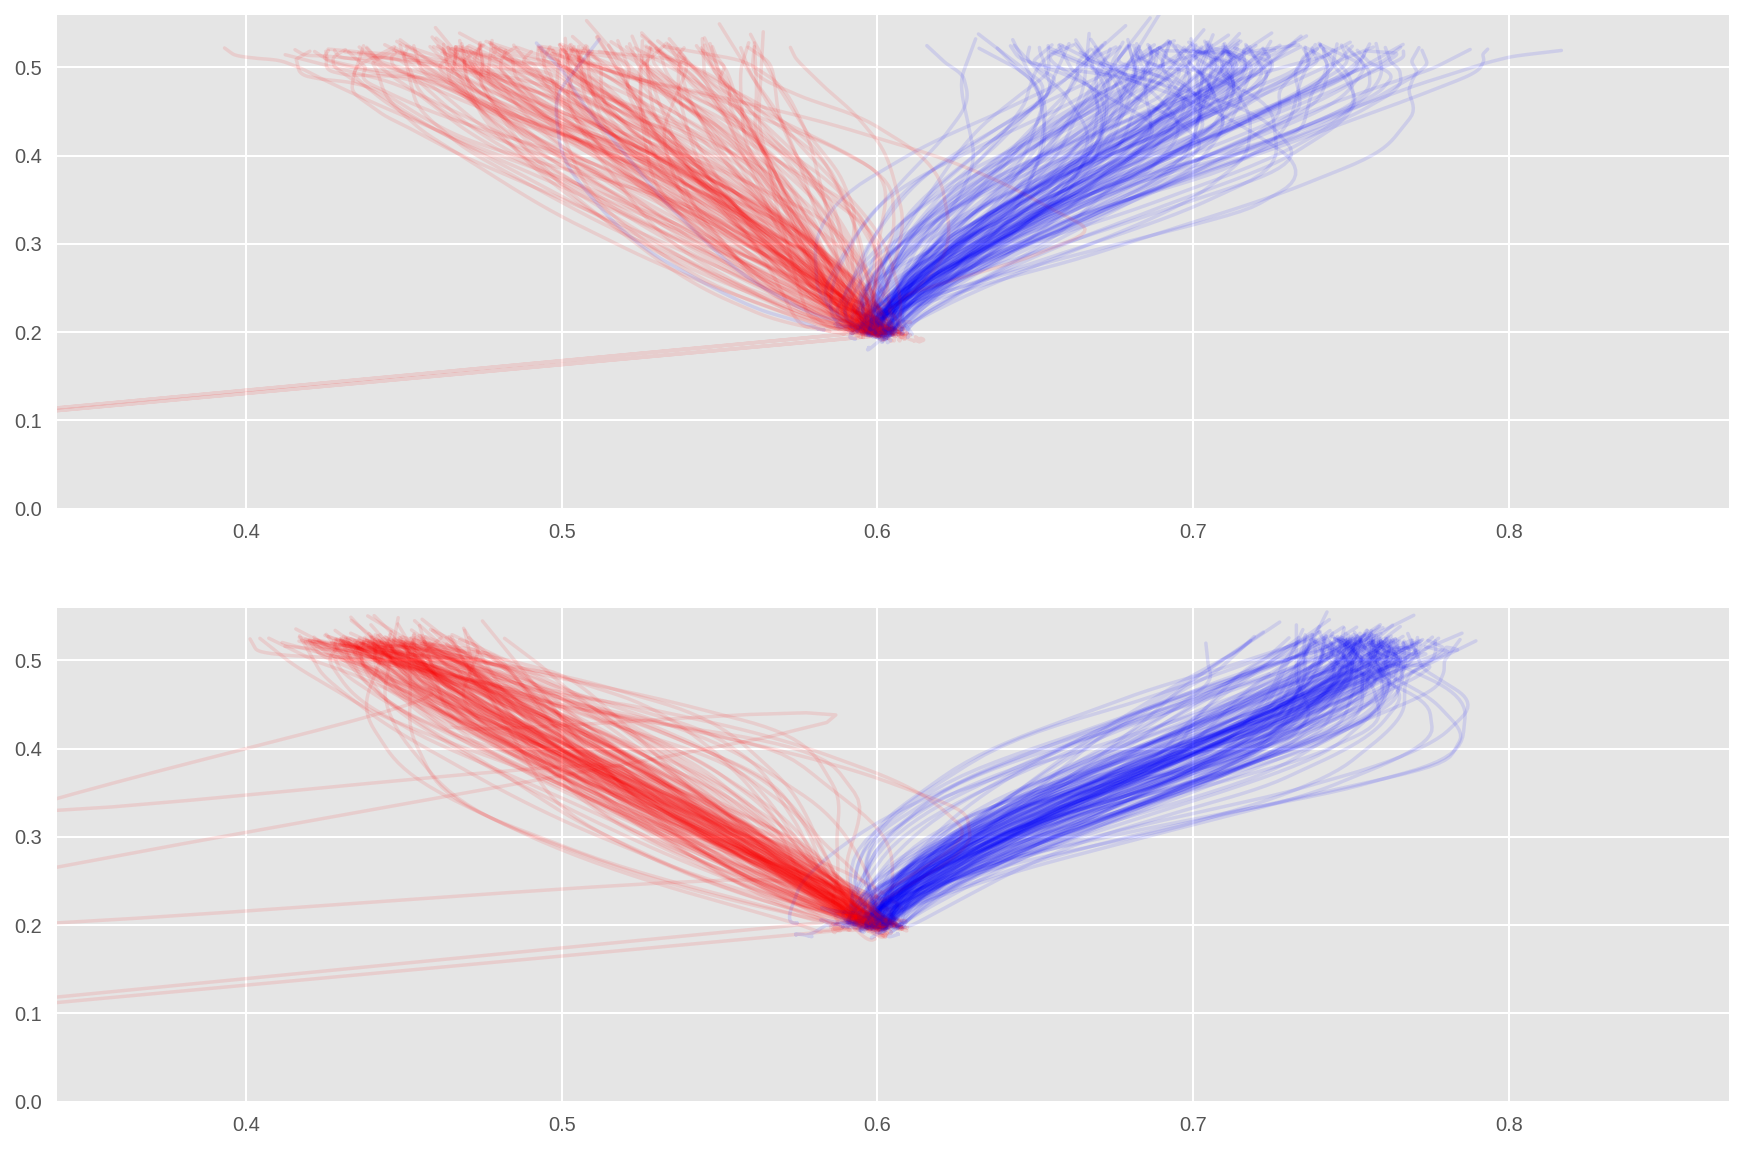

In [45]:
# Reach trajectories on x-y axes for index

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['index'] + 'x']
        y = trial[markers[pid]['index'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.56)
ax2.set_ylim(0, 0.56)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

### *Deviations from a staight line*

In [46]:
# Define a function that returns coordinates of a straight line connecting two points in 3d

def get_3d_line(vec_x, vec_y, vec_z):
        
    x0 = vec_x[0]; x1 = vec_x[-1]
    y0 = vec_y[0]; y1 = vec_y[-1]
    z0 = vec_z[0]; z1 = vec_z[-1]
    
    a = x1 - x0
    b = y1 - y0
    c = z1 - z0
   
    t = np.linspace(0, 1, len(vec_x))
    xs = np.array([x0 + t*a])
    ys = np.array([y0 + t*b])
    zs = np.array([z0 + t*c])
    
    return (xs[0], ys[0], zs[0])

918
True
True


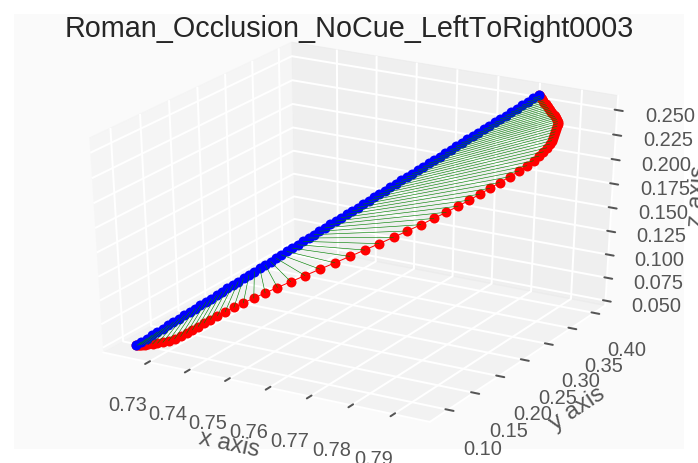

In [47]:
# %matplotlib qt

tr = d['P11']['trials']['t16']
ro = np.where(np.array(tr['startmovement']) == 1)[0][0]
print ro

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = tr['wrist11x'][ro:]
y = tr['wrist11y'][ro:]
z = tr['wrist11z'][ro:]

linex, liney, linez = get_3d_line(x, y, z)

print linex[0] == x[0]
print linex[-1] == x[-1]

# ax.plot(x, y, z, color = 'r')
# ax.plot([linex[0], linex[-1]], [liney[0], liney[-1]], [linez[0], linez[-1]], color = 'b', linewidth = 1)

ax.plot(x, y, z, 'r.-', markersize = 10, linewidth = 0.5)
ax.plot(linex, liney, linez, 'b.-', markersize = 10, linewidth = 0.5)

for i in range(len(x)):
    ax.plot([x[i], linex[i]],
            [y[i], liney[i]],
            [z[i], linez[i]], 'g-', linewidth = 0.3)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.set_title(tr['name'])
ax.set_facecolor([0.98, 0.98, 0.98])
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [48]:
x = np.array(x)

q = (x - x[0]) / (x - x[0])[-1]

q

array([ 0.        ,  0.00487979,  0.00977658,  0.01465637,  0.02181453,
        0.03307036,  0.04772673,  0.06505254,  0.08433366,  0.10487299,
        0.1259394 ,  0.14685279,  0.16686503,  0.18527902,  0.20265583,
        0.22003265,  0.23737545,  0.25582344,  0.2765158 ,  0.29958853,
        0.32512667,  0.35321522,  0.3839562 ,  0.41745163,  0.45380352,
        0.49309688,  0.53545074,  0.57933485,  0.62320196,  0.66700105,
        0.71042609,  0.75298398,  0.7944367 ,  0.8345632 ,  0.87307444,
        0.90974938,  0.94433298,  0.97658721,  1.00625701,  1.03310436,
        1.05843847,  1.08375557,  1.10902166,  1.13185636,  1.15016833,
        1.16433162,  1.17477131,  1.18186146,  1.18601013,  1.1876254 ,
        1.18709831,  1.18481994,  1.18121536,  1.17704968,  1.17290101,
        1.16875234,  1.16363451,  1.15688442,  1.14885912,  1.13996667,
        1.13061516,  1.12117863,  1.11182712,  1.1024926 ,  1.09317509,
        1.08385758,  1.07454008,  1.06522257,  1.05590506,  1.04

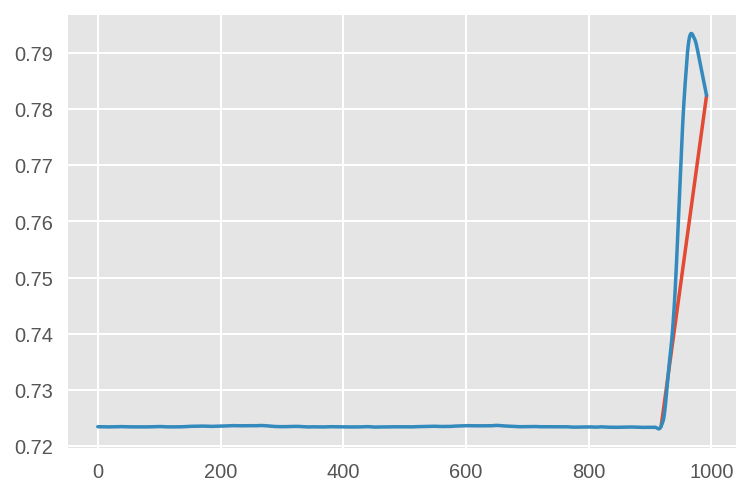

In [49]:
# % matplotlib inline

plt.plot(np.arange(len(linex)) + ro, linex)
plt.plot(tr['wrist11x'])
plt.show()

In [50]:
print x[-1]
print linex[-1]

0.782385
0.782385


## Linear models: predicting the grasp/gaze accuracy

In [51]:
# Get the index accuracy and mean distance of fixations table

mean_fixations = fixations.groupby(['p', 'trial'])['distance_to'] \
                          .apply(lambda x: np.mean(np.abs(x))) \
                          .reset_index()
        
# mean_fixations = fixations.groupby(['p', 'trial'])['distance_to'] \
#                           .apply(lambda x: np.mean(x)) \
#                           .reset_index()

In [52]:
common = pd.merge(mean_fixations, accuracies, on = ['p', 'trial'])
display(common[:10])

ocl = common[common['condition'] == 'Occlusion_Cue_LeftToRight']
onl = common[common['condition'] == 'Occlusion_NoCue_LeftToRight']

p trial  distance_to                    condition  eyes_object_final  \
0  P07    t1     0.017805    Occlusion_Cue_LeftToRight          -0.096329   
1  P07   t10     0.012794    Occlusion_Cue_RightToLeft          -0.058725   
2  P07   t11     0.014703    Occlusion_Cue_RightToLeft          -0.075704   
3  P07   t12     0.016460    Occlusion_Cue_RightToLeft          -0.090795   
4  P07   t13     0.021122  Occlusion_NoCue_LeftToRight          -0.007270   
5  P07   t15     0.021613  Occlusion_NoCue_LeftToRight          -0.099761   
6  P07   t16     0.018427  Occlusion_NoCue_LeftToRight          -0.057885   
7  P07   t17     0.017600  Occlusion_NoCue_LeftToRight          -0.054586   
8  P07   t18     0.018002  Occlusion_NoCue_LeftToRight          -0.056217   
9  P07   t19     0.018782  Occlusion_NoCue_RightToLeft          -0.052930   

   eyes_object_ro  index_object  peak_vel  reach_duration  reaction  ro_frame  \
0       -0.062740     -0.062737     975.0            63.0      64.0     944.0   
1       -0.024311     -0.059111     978.0            71.0      60.0     940.0   
2       -0.030204     -0.073226     975.0            92.0      56.0     936.0   
3       -0.045553     -0.071911     992.0           107.0      66.0     946.0   
4        0.008044     -0.009502     963.0            72.0      42.0     922.0   
5       -0.065825     -0.094429     958.0            91.0      41.0     921.0   
6       -0.042634     -0.040204     972.0            94.0      48.0     928.0   
7       -0.017586     -0.060545     955.0            75.0      47.0     927.0   
8       -0.028486     -0.073183     975.0            91.0      49.0     929.0   
9        0.000871     -0.055344     980.0           102.0      59.0     939.0   

   wrist_decel  
0         32.0  
1         33.0  
2         53.0  
3         61.0  
4         31.0  
5         54.0  
6         50.0  
7         47.0  
8         45.0  
9         61.0

r = 0.07
p = 0.522


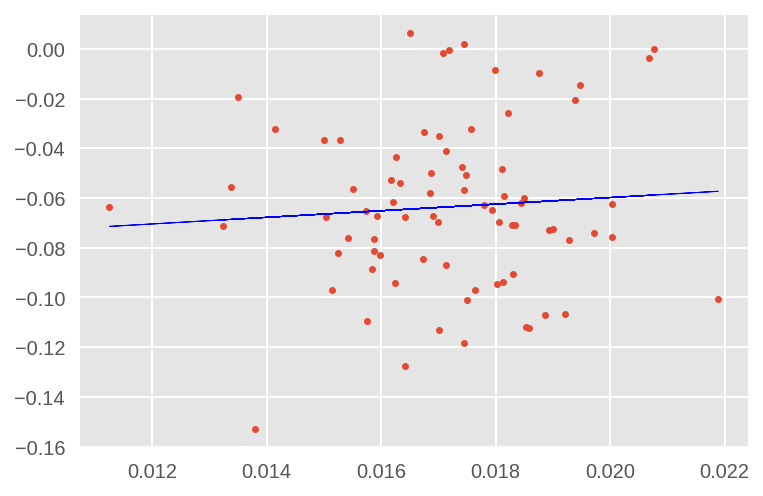

In [53]:
# Linear model grasp-obj distance ~ fixation-cue distance during pursuit

slope, intercept, r, p, stderr = linregress(ocl['distance_to'], ocl['index_object'])
print 'r = {}\np = {}'.format(round(r, 2), round(p, 3))

y = intercept + slope * ocl['distance_to']

plt.plot(ocl['distance_to'], ocl['index_object'], '.')
plt.plot(ocl['distance_to'], y, 'b-', linewidth = 0.5)
plt.show()

r = 0.15
p = 0.192


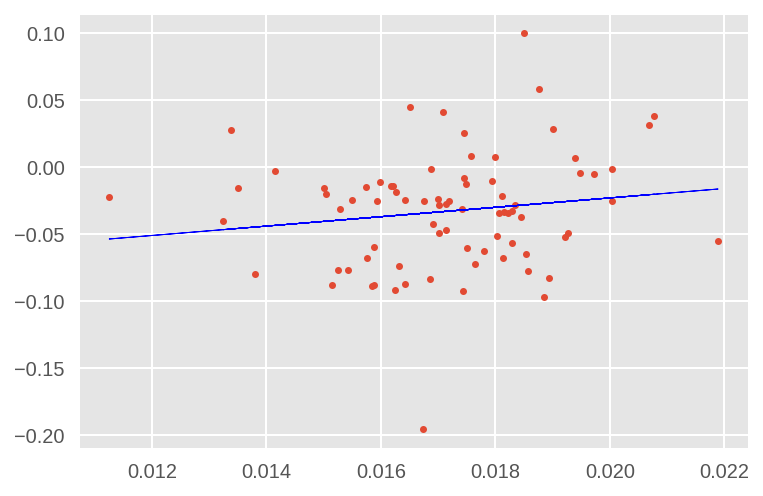

In [54]:
# Linear model gaze-obj distance at the reach onset ~ distance to cues during pursuit

slope, intercept, r, p, stderr = linregress(ocl['distance_to'], ocl['eyes_object_ro'])
print 'r = {}\np = {}'.format(round(r, 2), round(p, 3))

y = intercept + slope * ocl['distance_to']

plt.plot(ocl['distance_to'], ocl['eyes_object_ro'], '.')
plt.plot(ocl['distance_to'], y, 'b-', linewidth = 0.5)
plt.show()

## Root mean square error

In [55]:
def rmse(error):
    if not isinstance(error, np.ndarray):
        error = np.array(error)
    x = np.sqrt(np.mean(error**2))
    return x

In [56]:
rmse_data = pd.DataFrame()
error_vectors = {}

for pid, subj in d.items():
    error_vectors[pid] = {}
    for tid, trial in subj['trials'].items():
        ro_frame = np.where(np.array(trial['startmovement']) == 1)[0][0]
        error = np.array(trial['averagexeye'][496:ro_frame]) - np.array(trial['objectx'][496:ro_frame])
        
        error_vectors[pid][tid] = {}
        error_vectors[pid][tid]['condition'] = trial['name'][6:-4]
        error_vectors[pid][tid]['error'] = error
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['trial'] = tid
        to_add['condition'] = trial['name'][6:-4]
        to_add['rmse'] = rmse(error)
        
        rmse_data = rmse_data.append(to_add, ignore_index = True)

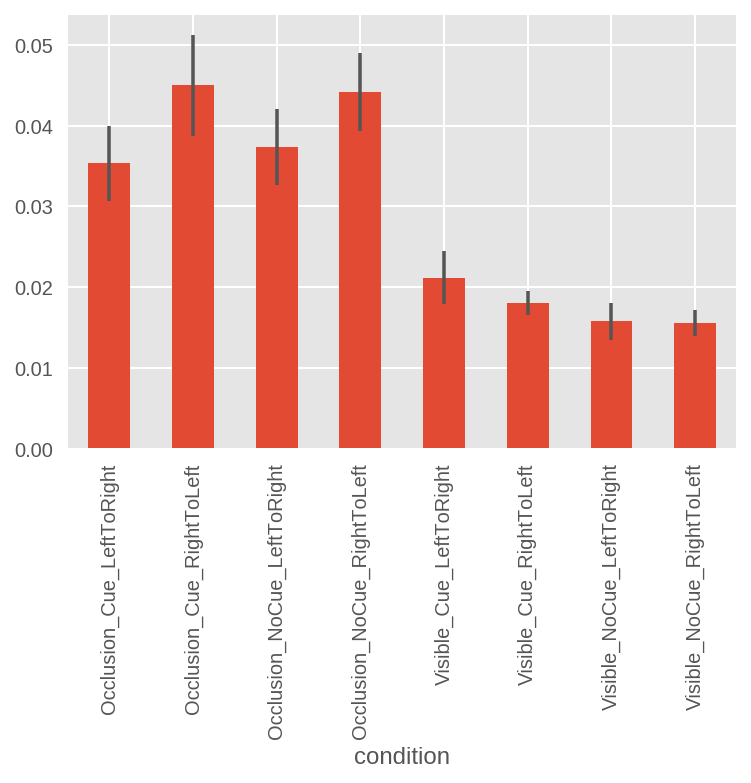

In [57]:
average_rmse = rmse_data.groupby(['p', 'condition'])['rmse'] \
                        .apply(np.mean) \
                        .reset_index() \
                        .pivot(index = 'p', columns = 'condition', values = 'rmse')
average_rmse.apply(np.mean).plot(kind = 'bar', yerr = np.std(average_rmse) / np.sqrt(len(average_rmse)))
plt.show()

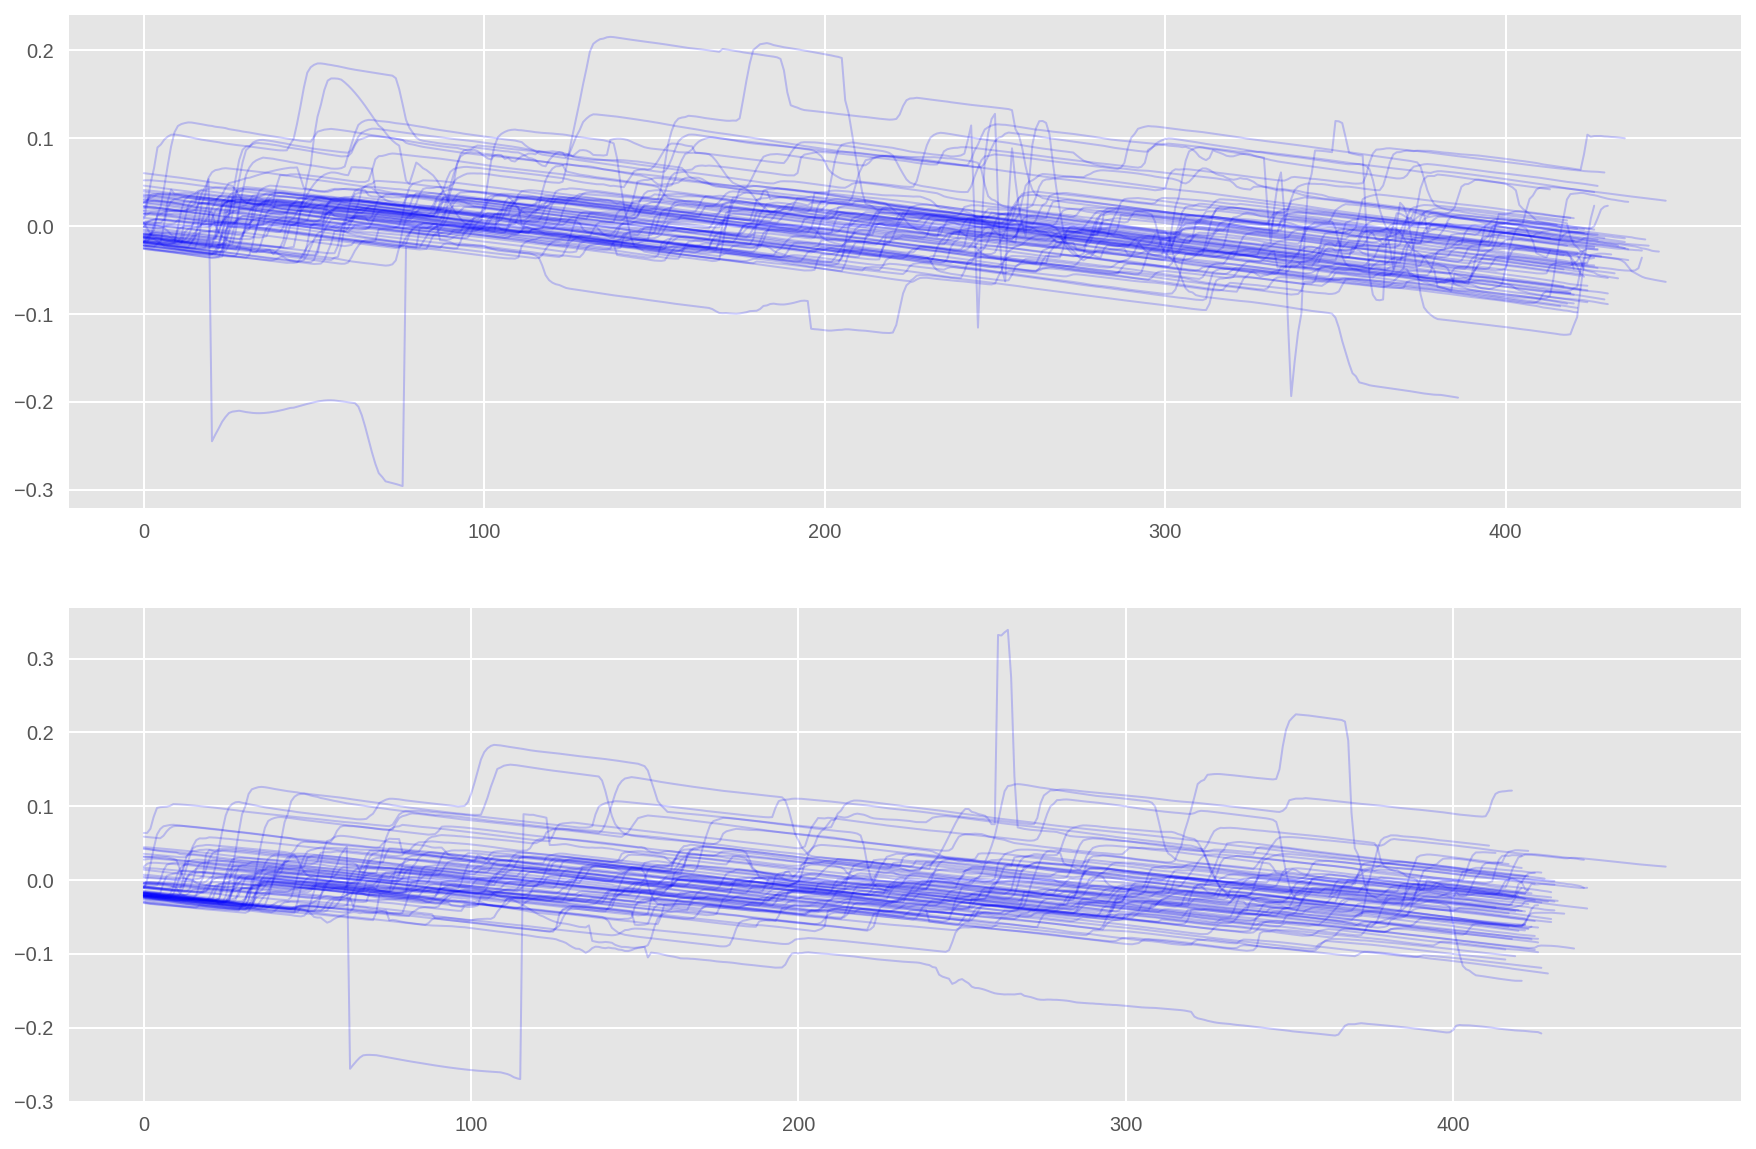

In [58]:
fig = plt.figure(figsize = [15,10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for p in error_vectors.values():
    for t in p.values():
        if 'Occlusion_Cue_LeftToRight' in t['condition']:
            ax1.plot(t['error'], 'b-', alpha = 0.2, linewidth = 1)
        elif 'Occlusion_NoCue_LeftToRight' in t['condition']:
            ax2.plot(t['error'], 'b-', alpha = 0.2, linewidth = 1)

plt.show()

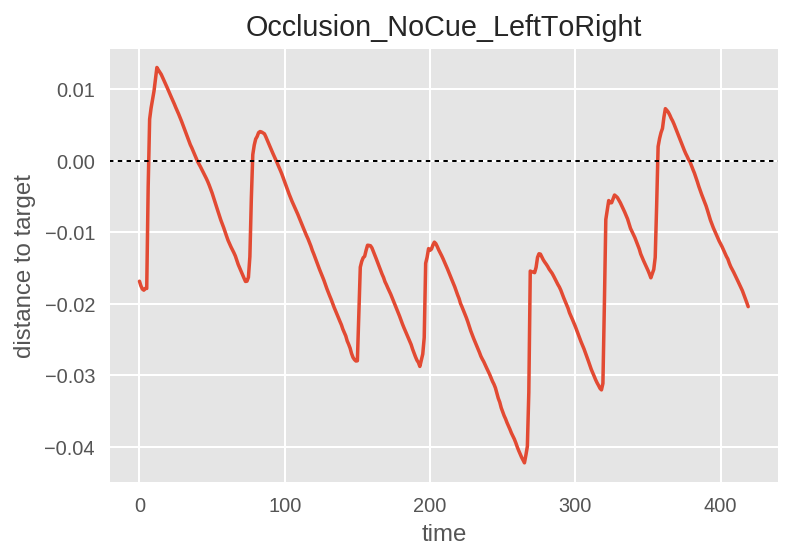

In [59]:
plt.plot(error_vectors['P12']['t16']['error'])
plt.title(error_vectors['P12']['t16']['condition'])
plt.axhline(0, color = 'k', linestyle = ':', linewidth = 1)
plt.xlabel('time')
plt.ylabel('distance to target')
plt.show()

## Saccades

In [60]:
saccades = pd.DataFrame()

for pid, subj in d.items():
    for tid, trial in subj['trials'].items():
                
        to_add = pd.DataFrame()
        
        ro_frame = np.where(np.array(trial['startmovement']) == 1)[0][0]
        
        ti = [] # time interval
        for frame in trial['fix']['start_frame'][1:]:
            if frame < 495:
                ti.append(0)
            elif 495 <= frame < ro_frame:
                ti.append(1)
            elif frame >= ro_frame:
                ti.append(2)
        
        to_add['ampl'] = np.absolute(np.diff(trial['fix']['centre_x']))
        to_add['ro_frame'] = ro_frame
        to_add['time_interval'] = ti
        
        to_add['p'] = pid
        to_add['condition'] = trial['name'][6:-4]
        to_add['trial'] = tid
        
        saccades = saccades.append(to_add, ignore_index = True)

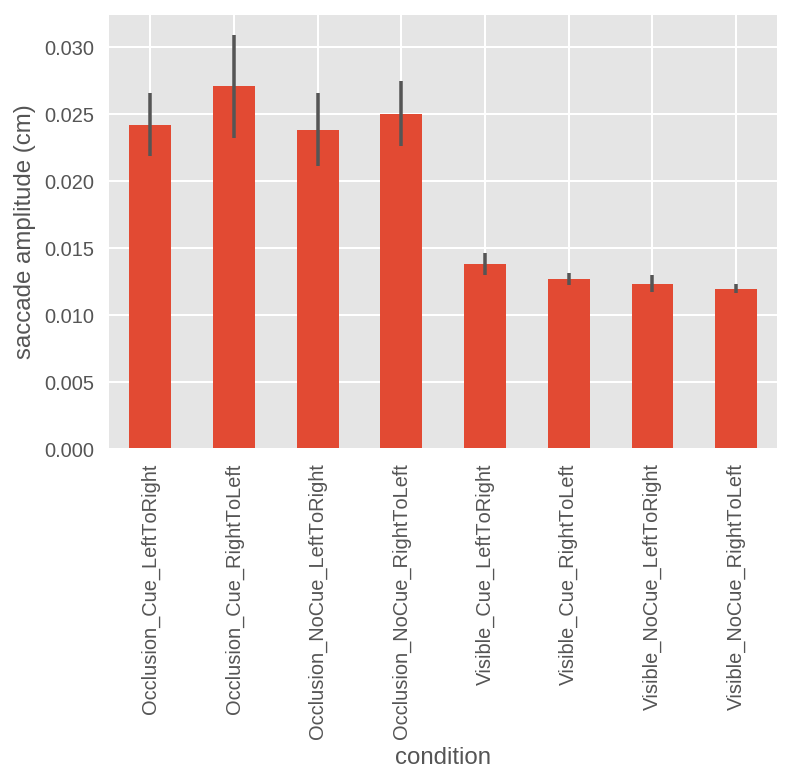

In [61]:
avgs = saccades[saccades.time_interval == 1] \
        .groupby(['p', 'condition'])['ampl'] \
        .apply(np.mean) \
        .reset_index() \
        .pivot(index = 'p', columns = 'condition', values = 'ampl')
        
avgs.apply(np.mean).plot(kind = 'bar', yerr = avgs.std() / np.sqrt(len(avgs)))
plt.ylabel('saccade amplitude (cm)')
plt.show()

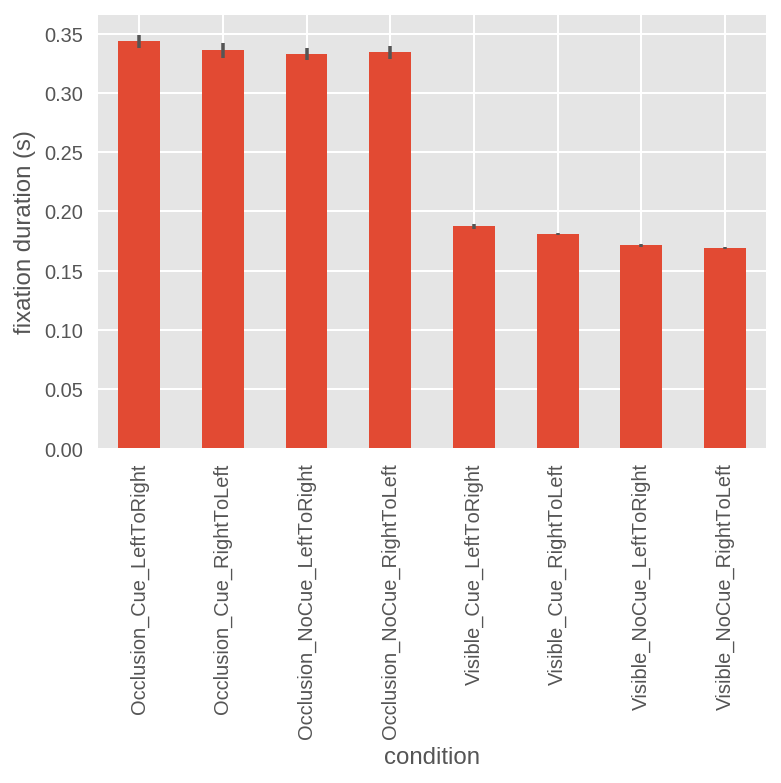

In [62]:
dur_avg = fixations[fixations.time_interval == 1] \
        .groupby(['p', 'condition'])['duration'] \
        .apply(np.mean) \
        .reset_index() \
        .pivot(index = 'p', columns = 'condition', values = 'duration')
dur_avg.apply(np.mean).plot(kind = 'bar', yerr = dur_avg.std() / len(dur_avg))
plt.ylabel('fixation duration (s)')
plt.show()

## Polar coordintaes

In [63]:
def find_mag_ang(x, z):
    '''Return magnitude (m) and angle (rad) given x and z displacements'''
    
    mag = np.sqrt(x**2 + z**2)
    
    if x > 0 and z > 0:
        ang = np.arctan(z/x) #* 180/np.pi
    elif x < 0 and z > 0:
        ang = np.pi + np.arctan(z/x) #* 180/np.pi
    elif x < 0 and z < 0:
        ang = np.pi + np.arctan(z/x) #* 180/np.pi
    elif x > 0 and z < 0:
        ang = 2 * np.pi + np.arctan(z/x) #* 180/np.pi
    
    return(mag, ang)

In [64]:
def angular_mean(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    x = np.sum(np.cos(angles))
    y = np.sum(np.sin(angles))
    
    ang_mean = np.arctan(y / x)
    
    if ang_mean < 0:
        ang_mean += 2 * np.pi
    
    return ang_mean

In [65]:
def ang_mean(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    y = np.sum(np.sin(angles)) / len(angles)
    x = np.sum(np.cos(angles)) / len(angles)
        
    if x > 0 and y > 0:
        mean = np.arctan(y / x)
    elif x < 0:
        mean = np.arctan(y / x) + np.pi
    elif y < 0 and x > 0:
        mean = np.arctan(y / x) + 2 * np.pi
    
    return mean

In [66]:
def ang_std(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    y = sum(np.sin(angles)) / len(angles)
    x = sum(np.cos(angles)) / len(angles)
    
    r = np.sqrt(x**2 + y**2)
    s = np.sqrt(-2 * np.log(r))
    
    return s

In [67]:
polar_accuracies = pd.DataFrame()

for pid, subj in d.items():
    for tid, trial in subj['trials'].items():
        acc_x = trial[markers[pid]['index'] + 'x'][-1] - trial['objectx'][-1]
        acc_z = trial[markers[pid]['index'] + 'z'][-1] - (trial['objectz'][-1] + 0.02)
        
        mag, ang = find_mag_ang(acc_x, acc_z)
        
        condition = trial['name'][6:-4]
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['trial'] = tid
        to_add['condition'] = condition
        to_add['mag'] = mag
        to_add['ang'] = ang
        
        polar_accuracies = polar_accuracies.append(to_add, ignore_index = True)

polar_accuracies = polar_accuracies[['p', 'condition', 'trial', 'mag', 'ang']]

In [68]:
polar_accuracies.head()

p                  condition trial       mag       ang
0  P16  Visible_NoCue_RightToLeft   t43  0.017616  1.919441
1  P16  Visible_NoCue_LeftToRight   t42  0.034824  3.198537
2  P16  Visible_NoCue_LeftToRight   t40  0.055668  1.325160
3  P16  Visible_NoCue_RightToLeft   t47  0.009218  0.440940
4  P16  Visible_NoCue_RightToLeft   t45  0.003193  4.802085

In [69]:
polar_avgs = polar_accuracies.groupby(['p', 'condition']) \
                             .aggregate({'mag': np.mean, 'ang': ang_mean}) \
                             .reset_index() \
                             .groupby('condition') \
                             .aggregate({'mag': [np.mean, np.std], 'ang': [ang_mean, ang_std]}) \
                             .reset_index(level = 'condition')
polar_avgs

condition       ang                 mag          
                                ang_mean   ang_std      mean       std
0    Occlusion_Cue_LeftToRight  3.158736  0.289349  0.066530  0.016579
1    Occlusion_Cue_RightToLeft  6.225664  0.337040  0.059837  0.018180
2  Occlusion_NoCue_LeftToRight  3.185347  0.183041  0.072581  0.028396
3  Occlusion_NoCue_RightToLeft  6.231880  0.411431  0.058508  0.025060
4      Visible_Cue_LeftToRight  3.040711  0.722905  0.017306  0.006092
5      Visible_Cue_RightToLeft  1.809945  2.193837  0.014383  0.006251
6    Visible_NoCue_LeftToRight  3.113773  0.534235  0.017659  0.005826
7    Visible_NoCue_RightToLeft  4.746945  1.919581  0.012937  0.004460

In [70]:
polar_avgs_occ = polar_avgs[polar_avgs['condition'].str.contains('Occlusion')]
polar_avgs_occ

condition       ang                 mag          
                                ang_mean   ang_std      mean       std
0    Occlusion_Cue_LeftToRight  3.158736  0.289349  0.066530  0.016579
1    Occlusion_Cue_RightToLeft  6.225664  0.337040  0.059837  0.018180
2  Occlusion_NoCue_LeftToRight  3.185347  0.183041  0.072581  0.028396
3  Occlusion_NoCue_RightToLeft  6.231880  0.411431  0.058508  0.025060

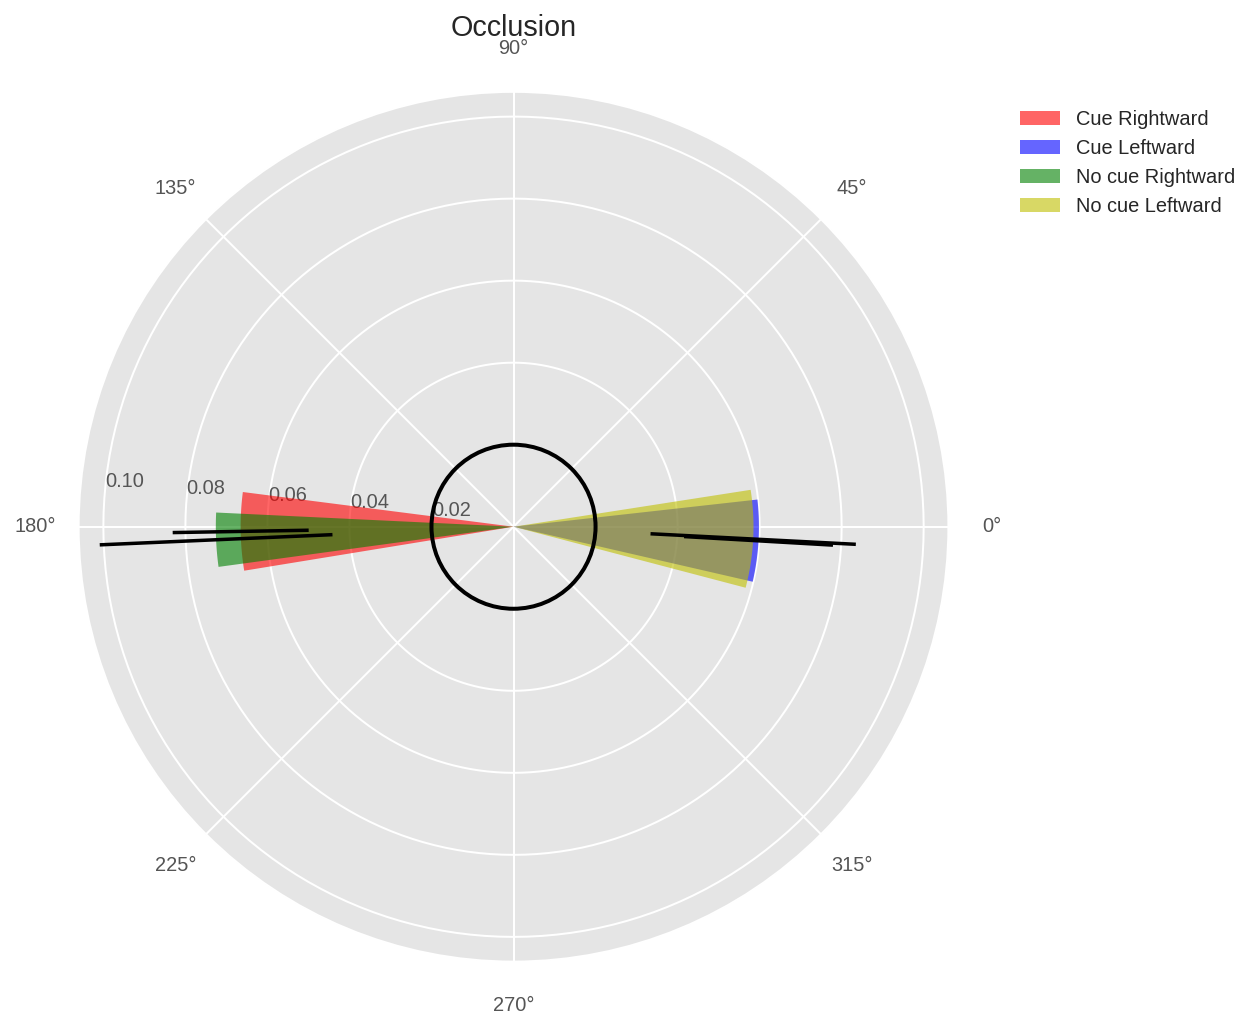

In [71]:
fig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(111, projection = 'polar')

bars = ax.bar(polar_avgs_occ['ang']['ang_mean'].as_matrix(), polar_avgs_occ['mag']['mean'].as_matrix(), 
              width = polar_avgs_occ['ang']['ang_std'].as_matrix(), 
              yerr = polar_avgs_occ['mag']['std'].as_matrix(), 
              alpha = 0.6, color = ['r', 'b', 'g', 'y'])

# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_Cue_LeftToRight']
# ax.plot(q['ang'], q['mag'], 'r.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_Cue_RightToLeft']
# ax.plot(q['ang'], q['mag'], 'b.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_NoCue_LeftToRight']
# ax.plot(q['ang'], q['mag'], 'g.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_NoCue_RightToLeft']
# ax.plot(q['ang'], q['mag'], 'y.', alpha = 0.5)

circle = plt.Circle((0, 0), 0.02, transform=ax.transData._b, color = 'k', fill = False, linewidth = 2)
ax.add_artist(circle)

ax.set_rlabel_position(175)
ax.legend(bars, ['Cue Rightward', 'Cue Leftward', 'No cue Rightward',
                 'No cue Leftward'], bbox_to_anchor = (1.35, 1))
ax.set_title('Occlusion')

plt.show()

In [72]:
polar_avgs_vis = polar_avgs[polar_avgs['condition'].str.contains('Visible')]

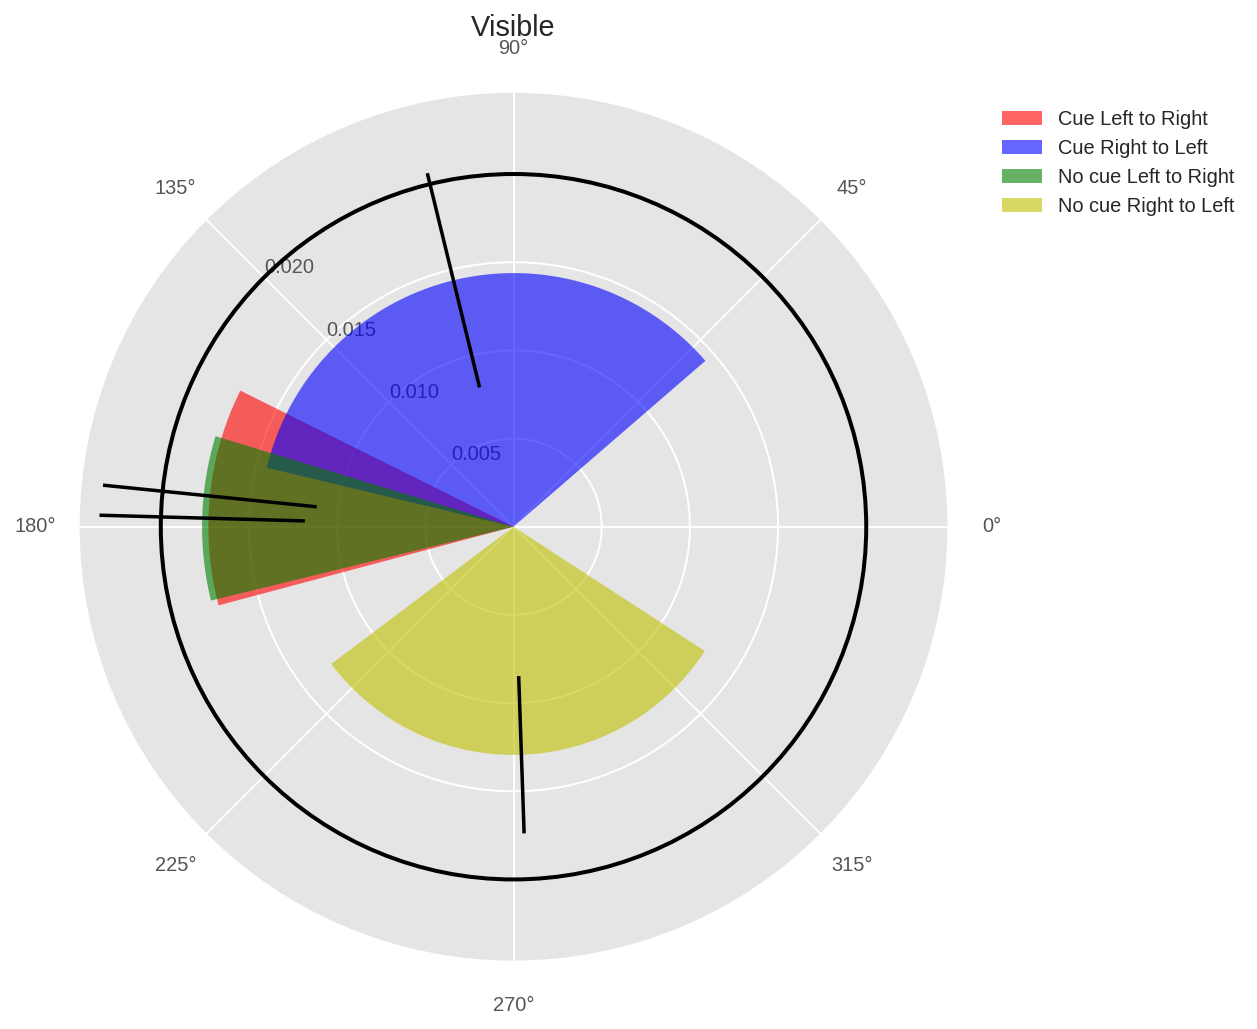

In [73]:
fig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(111, projection = 'polar')

bars = ax.bar(polar_avgs_vis['ang']['ang_mean'].as_matrix(), polar_avgs_vis['mag']['mean'].as_matrix(), 
              width = polar_avgs_vis['ang']['ang_std'].as_matrix(), 
              yerr = polar_avgs_vis['mag']['std'].as_matrix(), 
              alpha = 0.6, color = ['r', 'b', 'g', 'y'])

circle = plt.Circle((0, 0), 0.02, transform=ax.transData._b, color = 'k', fill = False, linewidth = 2)
ax.add_artist(circle)

ax.set_rlabel_position(135)
ax.legend(bars, ['Cue Left to Right', 'Cue Right to Left', 'No cue Left to Right',
                 'No cue Right to Left'], bbox_to_anchor = (1.35, 1))
ax.set_title('Visible')

plt.show()